In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.2 MB 14.9 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [38]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

In [39]:
role = sagemaker.get_execution_role()
bucket_name = 'segmentroads'
training_image = get_image_uri(boto3.Session().region_name, 'semantic-segmentation',
                              repo_version='latest')
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:latest


In [40]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']
for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

In [41]:
train_path = 'train/'
train_annotation_path = 'train_annotation/'
validation_path = 'validation/'
validation_annotation_path = 'validation_annotation/'

In [42]:
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('segmentroads')

In [43]:
s3_client = boto3.client('s3')
def get_s3_keys(bucket, prefix,list_objs):

    """Get a list of keys in an S3 bucket."""
    resp = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)
    for obj in resp['Contents']:
      files = obj['Key']
      fileName = files.split('/')[1]      
      list_objs.append(fileName)  
      #print(files)
    return files


sat_images =[]
masks_images =[]
get_s3_keys('segmentroads', 'satimg',sat_images)
get_s3_keys('segmentroads', 'masksimg',masks_images)

print(sat_images[:10],masks_images[:10])

['', '22679440_15.jpeg', '22679455_15.jpeg', '22679485_15.jpeg', '22828855_15.jpeg', '22828870_15.jpeg', '22828885_15.jpeg', '22828900_15.jpeg', '22828915_15.jpeg', '22828930_15.jpeg'] ['', '22679440_15.png', '22679455_15.png', '22679470_15.png', '22679485_15.png', '22828855_15.png', '22828870_15.png', '22828885_15.png', '22828900_15.png', '22828915_15.png']


In [44]:
s3_sat_path = 'sat/'
s3_masks_path = 'masks/'
s3_satimg_path = 'satimg/'
s3_masksimg_path = 'masksimg/'

In [47]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    print(map_file)
    assert map_file in masks_images
    return map_file
    
for image in tqdm(sat_images):
    image_png = image.split('.')[0] + '.png'
    if (image!='') and (image_png in masks_images):
        target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
          
        image_s3_path = s3_satimg_path + image
        if(target_set == 'train'):
            image_target_path = train_path + image
        else:
            image_target_path = validation_path + image

        masks_file_path = s3_masksimg_path + get_map_file(image)

        if(target_set == 'train'):
            masks_target_path = train_annotation_path + get_map_file(image)
        else:
            masks_target_path = validation_annotation_path + get_map_file(image)
    
        print(image_s3_path)
        print(masks_file_path)
        print(image_target_path)
        print(masks_target_path)
        s3.Object('segmentroads', image_target_path).copy_from(CopySource={'Bucket': 'segmentroads', 'Key': image_s3_path})
        s3.Object('segmentroads', masks_target_path).copy_from(CopySource={'Bucket': 'segmentroads', 'Key': masks_file_path})

    #shutil.copy(image_file_path, image_target_path)
    #shutil.copy(map_file_path, map_target_path)

  0%|          | 0/439 [00:00<?, ?it/s]

22679440_15.png
22679440_15.png
satimg/22679440_15.jpeg
masksimg/22679440_15.png
train/22679440_15.jpeg
train_annotation/22679440_15.png


  0%|          | 2/439 [00:00<01:09,  6.27it/s]

22679455_15.png
22679455_15.png
satimg/22679455_15.jpeg
masksimg/22679455_15.png
train/22679455_15.jpeg
train_annotation/22679455_15.png


  1%|          | 3/439 [00:00<01:19,  5.46it/s]

22679485_15.png
22679485_15.png
satimg/22679485_15.jpeg
masksimg/22679485_15.png
validation/22679485_15.jpeg
validation_annotation/22679485_15.png


  1%|          | 4/439 [00:00<01:27,  4.96it/s]

22828855_15.png
22828855_15.png
satimg/22828855_15.jpeg
masksimg/22828855_15.png
train/22828855_15.jpeg
train_annotation/22828855_15.png


  1%|          | 5/439 [00:01<01:28,  4.92it/s]

22828870_15.png
22828870_15.png
satimg/22828870_15.jpeg
masksimg/22828870_15.png
validation/22828870_15.jpeg
validation_annotation/22828870_15.png


  1%|▏         | 6/439 [00:01<01:42,  4.24it/s]

22828885_15.png
22828885_15.png
satimg/22828885_15.jpeg
masksimg/22828885_15.png
validation/22828885_15.jpeg
validation_annotation/22828885_15.png


  2%|▏         | 7/439 [00:01<01:55,  3.73it/s]

22828900_15.png
22828900_15.png
satimg/22828900_15.jpeg
masksimg/22828900_15.png
train/22828900_15.jpeg
train_annotation/22828900_15.png


  2%|▏         | 9/439 [00:02<01:44,  4.12it/s]

22828915_15.png
22828915_15.png
satimg/22828915_15.jpeg
masksimg/22828915_15.png
train/22828915_15.jpeg
train_annotation/22828915_15.png
22828930_15.png
22828930_15.png
satimg/22828930_15.jpeg
masksimg/22828930_15.png
train/22828930_15.jpeg
train_annotation/22828930_15.png


  2%|▏         | 10/439 [00:02<01:41,  4.22it/s]

22828945_15.png
22828945_15.png
satimg/22828945_15.jpeg
masksimg/22828945_15.png
train/22828945_15.jpeg
train_annotation/22828945_15.png


  3%|▎         | 12/439 [00:02<01:38,  4.35it/s]

22828960_15.png
22828960_15.png
satimg/22828960_15.jpeg
masksimg/22828960_15.png
train/22828960_15.jpeg
train_annotation/22828960_15.png
22828975_15.png
22828975_15.png
satimg/22828975_15.jpeg
masksimg/22828975_15.png
train/22828975_15.jpeg
train_annotation/22828975_15.png


  3%|▎         | 13/439 [00:03<01:40,  4.24it/s]

22828990_15.png
22828990_15.png
satimg/22828990_15.jpeg
masksimg/22828990_15.png
train/22828990_15.jpeg
train_annotation/22828990_15.png


  3%|▎         | 14/439 [00:03<01:40,  4.21it/s]

22829005_15.png
22829005_15.png
satimg/22829005_15.jpeg
masksimg/22829005_15.png
train/22829005_15.jpeg
train_annotation/22829005_15.png


  3%|▎         | 15/439 [00:03<01:36,  4.38it/s]

22829020_15.png
22829020_15.png
satimg/22829020_15.jpeg
masksimg/22829020_15.png
train/22829020_15.jpeg
train_annotation/22829020_15.png


  4%|▎         | 16/439 [00:03<01:36,  4.39it/s]

22829050_15.png
22829050_15.png
satimg/22829050_15.jpeg
masksimg/22829050_15.png
train/22829050_15.jpeg
train_annotation/22829050_15.png


  4%|▍         | 17/439 [00:03<01:33,  4.53it/s]

22829065_15.png
22829065_15.png
satimg/22829065_15.jpeg
masksimg/22829065_15.png
train/22829065_15.jpeg
train_annotation/22829065_15.png


  4%|▍         | 18/439 [00:04<01:35,  4.43it/s]

22829410_15.png
22829410_15.png
satimg/22829410_15.jpeg
masksimg/22829410_15.png
validation/22829410_15.jpeg
validation_annotation/22829410_15.png


  4%|▍         | 19/439 [00:04<01:37,  4.29it/s]

22829425_15.png
22829425_15.png
satimg/22829425_15.jpeg
masksimg/22829425_15.png
train/22829425_15.jpeg
train_annotation/22829425_15.png


  5%|▍         | 20/439 [00:04<01:40,  4.18it/s]

22829440_15.png
22829440_15.png
satimg/22829440_15.jpeg
masksimg/22829440_15.png
train/22829440_15.jpeg
train_annotation/22829440_15.png


  5%|▍         | 21/439 [00:04<01:37,  4.31it/s]

22829455_15.png
22829455_15.png
satimg/22829455_15.jpeg
masksimg/22829455_15.png
train/22829455_15.jpeg
train_annotation/22829455_15.png


  5%|▌         | 22/439 [00:05<02:11,  3.17it/s]

22829470_15.png
22829470_15.png
satimg/22829470_15.jpeg
masksimg/22829470_15.png
train/22829470_15.jpeg
train_annotation/22829470_15.png


  5%|▌         | 24/439 [00:05<01:47,  3.86it/s]

22829485_15.png
22829485_15.png
satimg/22829485_15.jpeg
masksimg/22829485_15.png
train/22829485_15.jpeg
train_annotation/22829485_15.png
22978840_15.png
22978840_15.png
satimg/22978840_15.jpeg
masksimg/22978840_15.png
train/22978840_15.jpeg
train_annotation/22978840_15.png


  6%|▌         | 25/439 [00:06<01:47,  3.84it/s]

22978855_15.png
22978855_15.png
satimg/22978855_15.jpeg
masksimg/22978855_15.png
train/22978855_15.jpeg
train_annotation/22978855_15.png


  6%|▌         | 26/439 [00:06<01:44,  3.94it/s]

22978870_15.png
22978870_15.png
satimg/22978870_15.jpeg
masksimg/22978870_15.png
train/22978870_15.jpeg
train_annotation/22978870_15.png


  6%|▌         | 27/439 [00:06<01:42,  4.02it/s]

22978885_15.png
22978885_15.png
satimg/22978885_15.jpeg
masksimg/22978885_15.png
train/22978885_15.jpeg
train_annotation/22978885_15.png


  6%|▋         | 28/439 [00:06<01:37,  4.21it/s]

22978900_15.png
22978900_15.png
satimg/22978900_15.jpeg
masksimg/22978900_15.png
train/22978900_15.jpeg
train_annotation/22978900_15.png


  7%|▋         | 29/439 [00:07<01:45,  3.88it/s]

22978915_15.png
22978915_15.png
satimg/22978915_15.jpeg
masksimg/22978915_15.png
train/22978915_15.jpeg
train_annotation/22978915_15.png


  7%|▋         | 31/439 [00:07<01:48,  3.76it/s]

22978930_15.png
22978930_15.png
satimg/22978930_15.jpeg
masksimg/22978930_15.png
train/22978930_15.jpeg
train_annotation/22978930_15.png
22978945_15.png
22978945_15.png
satimg/22978945_15.jpeg
masksimg/22978945_15.png
train/22978945_15.jpeg
train_annotation/22978945_15.png


  7%|▋         | 32/439 [00:07<01:42,  3.95it/s]

22978960_15.png
22978960_15.png
satimg/22978960_15.jpeg
masksimg/22978960_15.png
train/22978960_15.jpeg
train_annotation/22978960_15.png


  8%|▊         | 33/439 [00:08<01:50,  3.66it/s]

22978975_15.png
22978975_15.png
satimg/22978975_15.jpeg
masksimg/22978975_15.png
train/22978975_15.jpeg
train_annotation/22978975_15.png


  8%|▊         | 34/439 [00:08<01:42,  3.95it/s]

22979005_15.png
22979005_15.png
satimg/22979005_15.jpeg
masksimg/22979005_15.png
train/22979005_15.jpeg
train_annotation/22979005_15.png


  8%|▊         | 35/439 [00:08<01:36,  4.17it/s]

22979020_15.png
22979020_15.png
satimg/22979020_15.jpeg
masksimg/22979020_15.png
train/22979020_15.jpeg
train_annotation/22979020_15.png


  8%|▊         | 36/439 [00:08<01:44,  3.84it/s]

22979035_15.png
22979035_15.png
satimg/22979035_15.jpeg
masksimg/22979035_15.png
train/22979035_15.jpeg
train_annotation/22979035_15.png


  9%|▊         | 38/439 [00:09<01:36,  4.13it/s]

22979050_15.png
22979050_15.png
satimg/22979050_15.jpeg
masksimg/22979050_15.png
train/22979050_15.jpeg
train_annotation/22979050_15.png
22979065_15.png
22979065_15.png
satimg/22979065_15.jpeg
masksimg/22979065_15.png
validation/22979065_15.jpeg
validation_annotation/22979065_15.png


  9%|▉         | 39/439 [00:09<01:31,  4.36it/s]

22979410_15.png
22979410_15.png
satimg/22979410_15.jpeg
masksimg/22979410_15.png
train/22979410_15.jpeg
train_annotation/22979410_15.png


  9%|▉         | 40/439 [00:09<01:31,  4.36it/s]

22979425_15.png
22979425_15.png
satimg/22979425_15.jpeg
masksimg/22979425_15.png
validation/22979425_15.jpeg
validation_annotation/22979425_15.png


  9%|▉         | 41/439 [00:10<01:30,  4.42it/s]

22979440_15.png
22979440_15.png
satimg/22979440_15.jpeg
masksimg/22979440_15.png
train/22979440_15.jpeg
train_annotation/22979440_15.png


 10%|▉         | 42/439 [00:10<01:53,  3.51it/s]

22979455_15.png
22979455_15.png
satimg/22979455_15.jpeg
masksimg/22979455_15.png
validation/22979455_15.jpeg
validation_annotation/22979455_15.png


 10%|▉         | 43/439 [00:10<01:50,  3.57it/s]

22979470_15.png
22979470_15.png
satimg/22979470_15.jpeg
masksimg/22979470_15.png
train/22979470_15.jpeg
train_annotation/22979470_15.png


 10%|█         | 44/439 [00:11<02:07,  3.09it/s]

23128870_15.png
23128870_15.png
satimg/23128870_15.jpeg
masksimg/23128870_15.png
train/23128870_15.jpeg
train_annotation/23128870_15.png


 10%|█         | 45/439 [00:11<02:03,  3.20it/s]

23128885_15.png
23128885_15.png
satimg/23128885_15.jpeg
masksimg/23128885_15.png
train/23128885_15.jpeg
train_annotation/23128885_15.png


 10%|█         | 46/439 [00:11<02:09,  3.04it/s]

23128900_15.png
23128900_15.png
satimg/23128900_15.jpeg
masksimg/23128900_15.png
train/23128900_15.jpeg
train_annotation/23128900_15.png


 11%|█         | 47/439 [00:12<01:58,  3.32it/s]

23128915_15.png
23128915_15.png
satimg/23128915_15.jpeg
masksimg/23128915_15.png
train/23128915_15.jpeg
train_annotation/23128915_15.png


 11%|█         | 48/439 [00:12<01:48,  3.60it/s]

23128945_15.png
23128945_15.png
satimg/23128945_15.jpeg
masksimg/23128945_15.png
validation/23128945_15.jpeg
validation_annotation/23128945_15.png


 11%|█         | 49/439 [00:12<01:42,  3.81it/s]

23128960_15.png
23128960_15.png
satimg/23128960_15.jpeg
masksimg/23128960_15.png
train/23128960_15.jpeg
train_annotation/23128960_15.png


 11%|█▏        | 50/439 [00:12<02:04,  3.12it/s]

23128975_15.png
23128975_15.png
satimg/23128975_15.jpeg
masksimg/23128975_15.png
train/23128975_15.jpeg
train_annotation/23128975_15.png


 12%|█▏        | 51/439 [00:13<02:04,  3.11it/s]

23128990_15.png
23128990_15.png
satimg/23128990_15.jpeg
masksimg/23128990_15.png
train/23128990_15.jpeg
train_annotation/23128990_15.png


 12%|█▏        | 52/439 [00:13<01:50,  3.49it/s]

23129005_15.png
23129005_15.png
satimg/23129005_15.jpeg
masksimg/23129005_15.png
validation/23129005_15.jpeg
validation_annotation/23129005_15.png


 12%|█▏        | 53/439 [00:13<01:46,  3.62it/s]

23129020_15.png
23129020_15.png
satimg/23129020_15.jpeg
masksimg/23129020_15.png
train/23129020_15.jpeg
train_annotation/23129020_15.png


 13%|█▎        | 55/439 [00:14<01:32,  4.16it/s]

23129035_15.png
23129035_15.png
satimg/23129035_15.jpeg
masksimg/23129035_15.png
train/23129035_15.jpeg
train_annotation/23129035_15.png
23129050_15.png
23129050_15.png
satimg/23129050_15.jpeg
masksimg/23129050_15.png
train/23129050_15.jpeg
train_annotation/23129050_15.png


 13%|█▎        | 56/439 [00:14<01:36,  3.97it/s]

23129065_15.png
23129065_15.png
satimg/23129065_15.jpeg
masksimg/23129065_15.png
validation/23129065_15.jpeg
validation_annotation/23129065_15.png


 13%|█▎        | 58/439 [00:14<01:35,  4.01it/s]

23129110_15.png
23129110_15.png
satimg/23129110_15.jpeg
masksimg/23129110_15.png
train/23129110_15.jpeg
train_annotation/23129110_15.png
23129125_15.png
23129125_15.png
satimg/23129125_15.jpeg
masksimg/23129125_15.png
train/23129125_15.jpeg
train_annotation/23129125_15.png


 13%|█▎        | 59/439 [00:15<01:29,  4.23it/s]

23129140_15.png
23129140_15.png
satimg/23129140_15.jpeg
masksimg/23129140_15.png
train/23129140_15.jpeg
train_annotation/23129140_15.png


 14%|█▍        | 61/439 [00:15<01:22,  4.60it/s]

23129155_15.png
23129155_15.png
satimg/23129155_15.jpeg
masksimg/23129155_15.png
train/23129155_15.jpeg
train_annotation/23129155_15.png
23129170_15.png
23129170_15.png
satimg/23129170_15.jpeg
masksimg/23129170_15.png
train/23129170_15.jpeg
train_annotation/23129170_15.png


 14%|█▍        | 62/439 [00:15<01:26,  4.35it/s]

23129410_15.png
23129410_15.png
satimg/23129410_15.jpeg
masksimg/23129410_15.png
train/23129410_15.jpeg
train_annotation/23129410_15.png


 14%|█▍        | 63/439 [00:16<01:30,  4.17it/s]

23129425_15.png
23129425_15.png
satimg/23129425_15.jpeg
masksimg/23129425_15.png
train/23129425_15.jpeg
train_annotation/23129425_15.png


 15%|█▍        | 64/439 [00:16<01:31,  4.11it/s]

23129440_15.png
23129440_15.png
satimg/23129440_15.jpeg
masksimg/23129440_15.png
train/23129440_15.jpeg
train_annotation/23129440_15.png


 15%|█▍        | 65/439 [00:16<01:30,  4.14it/s]

23129455_15.png
23129455_15.png
satimg/23129455_15.jpeg
masksimg/23129455_15.png
train/23129455_15.jpeg
train_annotation/23129455_15.png


 15%|█▌        | 66/439 [00:16<01:31,  4.09it/s]

23278825_15.png
23278825_15.png
satimg/23278825_15.jpeg
masksimg/23278825_15.png
validation/23278825_15.jpeg
validation_annotation/23278825_15.png


 15%|█▌        | 67/439 [00:17<01:33,  3.98it/s]

23278840_15.png
23278840_15.png
satimg/23278840_15.jpeg
masksimg/23278840_15.png
train/23278840_15.jpeg
train_annotation/23278840_15.png


 16%|█▌        | 69/439 [00:17<01:24,  4.35it/s]

23278885_15.png
23278885_15.png
satimg/23278885_15.jpeg
masksimg/23278885_15.png
train/23278885_15.jpeg
train_annotation/23278885_15.png
23278900_15.png
23278900_15.png
satimg/23278900_15.jpeg
masksimg/23278900_15.png
train/23278900_15.jpeg
train_annotation/23278900_15.png


 16%|█▌        | 70/439 [00:17<01:25,  4.30it/s]

23278945_15.png
23278945_15.png
satimg/23278945_15.jpeg
masksimg/23278945_15.png
train/23278945_15.jpeg
train_annotation/23278945_15.png


 16%|█▋        | 72/439 [00:18<01:22,  4.43it/s]

23278960_15.png
23278960_15.png
satimg/23278960_15.jpeg
masksimg/23278960_15.png
validation/23278960_15.jpeg
validation_annotation/23278960_15.png
23278975_15.png
23278975_15.png
satimg/23278975_15.jpeg
masksimg/23278975_15.png
train/23278975_15.jpeg
train_annotation/23278975_15.png


 17%|█▋        | 74/439 [00:18<01:19,  4.58it/s]

23278990_15.png
23278990_15.png
satimg/23278990_15.jpeg
masksimg/23278990_15.png
train/23278990_15.jpeg
train_annotation/23278990_15.png
23279005_15.png
23279005_15.png
satimg/23279005_15.jpeg
masksimg/23279005_15.png
train/23279005_15.jpeg
train_annotation/23279005_15.png


 17%|█▋        | 75/439 [00:18<01:18,  4.63it/s]

23279020_15.png
23279020_15.png
satimg/23279020_15.jpeg
masksimg/23279020_15.png
train/23279020_15.jpeg
train_annotation/23279020_15.png


 17%|█▋        | 76/439 [00:19<01:19,  4.55it/s]

23279035_15.png
23279035_15.png
satimg/23279035_15.jpeg
masksimg/23279035_15.png
train/23279035_15.jpeg
train_annotation/23279035_15.png


 18%|█▊        | 78/439 [00:19<01:19,  4.53it/s]

23279050_15.png
23279050_15.png
satimg/23279050_15.jpeg
masksimg/23279050_15.png
train/23279050_15.jpeg
train_annotation/23279050_15.png
23279080_15.png
23279080_15.png
satimg/23279080_15.jpeg
masksimg/23279080_15.png
train/23279080_15.jpeg
train_annotation/23279080_15.png


 18%|█▊        | 79/439 [00:19<01:19,  4.52it/s]

23279095_15.png
23279095_15.png
satimg/23279095_15.jpeg
masksimg/23279095_15.png
train/23279095_15.jpeg
train_annotation/23279095_15.png


 18%|█▊        | 80/439 [00:20<01:26,  4.14it/s]

23279110_15.png
23279110_15.png
satimg/23279110_15.jpeg
masksimg/23279110_15.png
train/23279110_15.jpeg
train_annotation/23279110_15.png


 18%|█▊        | 81/439 [00:20<01:30,  3.97it/s]

23279125_15.png
23279125_15.png
satimg/23279125_15.jpeg
masksimg/23279125_15.png
train/23279125_15.jpeg
train_annotation/23279125_15.png


 19%|█▊        | 82/439 [00:20<01:25,  4.19it/s]

23279140_15.png
23279140_15.png
satimg/23279140_15.jpeg
masksimg/23279140_15.png
train/23279140_15.jpeg
train_annotation/23279140_15.png


 19%|█▉        | 83/439 [00:20<01:26,  4.10it/s]

23279155_15.png
23279155_15.png
satimg/23279155_15.jpeg
masksimg/23279155_15.png
validation/23279155_15.jpeg
validation_annotation/23279155_15.png


 19%|█▉        | 84/439 [00:21<01:27,  4.06it/s]

23279170_15.png
23279170_15.png
satimg/23279170_15.jpeg
masksimg/23279170_15.png
train/23279170_15.jpeg
train_annotation/23279170_15.png


 20%|█▉        | 86/439 [00:21<01:23,  4.23it/s]

23428510_15.png
23428510_15.png
satimg/23428510_15.jpeg
masksimg/23428510_15.png
train/23428510_15.jpeg
train_annotation/23428510_15.png
23428525_15.png
23428525_15.png
satimg/23428525_15.jpeg
masksimg/23428525_15.png
train/23428525_15.jpeg
train_annotation/23428525_15.png


 20%|█▉        | 87/439 [00:21<01:35,  3.69it/s]

23428555_15.png
23428555_15.png
satimg/23428555_15.jpeg
masksimg/23428555_15.png
train/23428555_15.jpeg
train_annotation/23428555_15.png


 20%|██        | 89/439 [00:22<01:20,  4.33it/s]

23428570_15.png
23428570_15.png
satimg/23428570_15.jpeg
masksimg/23428570_15.png
train/23428570_15.jpeg
train_annotation/23428570_15.png
23428585_15.png
23428585_15.png
satimg/23428585_15.jpeg
masksimg/23428585_15.png
train/23428585_15.jpeg
train_annotation/23428585_15.png


 21%|██        | 91/439 [00:22<01:24,  4.12it/s]

23428825_15.png
23428825_15.png
satimg/23428825_15.jpeg
masksimg/23428825_15.png
train/23428825_15.jpeg
train_annotation/23428825_15.png
23428840_15.png
23428840_15.png
satimg/23428840_15.jpeg
masksimg/23428840_15.png
validation/23428840_15.jpeg
validation_annotation/23428840_15.png


 21%|██        | 92/439 [00:22<01:19,  4.39it/s]

23428900_15.png
23428900_15.png
satimg/23428900_15.jpeg
masksimg/23428900_15.png
train/23428900_15.jpeg
train_annotation/23428900_15.png


 21%|██        | 93/439 [00:23<01:23,  4.16it/s]

23428915_15.png
23428915_15.png
satimg/23428915_15.jpeg
masksimg/23428915_15.png
train/23428915_15.jpeg
train_annotation/23428915_15.png


 21%|██▏       | 94/439 [00:23<01:28,  3.89it/s]

23428930_15.png
23428930_15.png
satimg/23428930_15.jpeg
masksimg/23428930_15.png
train/23428930_15.jpeg
train_annotation/23428930_15.png


 22%|██▏       | 95/439 [00:23<01:34,  3.65it/s]

23428945_15.png
23428945_15.png
satimg/23428945_15.jpeg
masksimg/23428945_15.png
train/23428945_15.jpeg
train_annotation/23428945_15.png


 22%|██▏       | 96/439 [00:24<01:32,  3.72it/s]

23428960_15.png
23428960_15.png
satimg/23428960_15.jpeg
masksimg/23428960_15.png
train/23428960_15.jpeg
train_annotation/23428960_15.png


 22%|██▏       | 97/439 [00:24<01:30,  3.77it/s]

23428975_15.png
23428975_15.png
satimg/23428975_15.jpeg
masksimg/23428975_15.png
train/23428975_15.jpeg
train_annotation/23428975_15.png


 22%|██▏       | 98/439 [00:24<01:39,  3.43it/s]

23428990_15.png
23428990_15.png
satimg/23428990_15.jpeg
masksimg/23428990_15.png
train/23428990_15.jpeg
train_annotation/23428990_15.png


 23%|██▎       | 99/439 [00:25<01:37,  3.48it/s]

23429005_15.png
23429005_15.png
satimg/23429005_15.jpeg
masksimg/23429005_15.png
train/23429005_15.jpeg
train_annotation/23429005_15.png


 23%|██▎       | 100/439 [00:25<01:34,  3.60it/s]

23429020_15.png
23429020_15.png
satimg/23429020_15.jpeg
masksimg/23429020_15.png
train/23429020_15.jpeg
train_annotation/23429020_15.png


 23%|██▎       | 101/439 [00:25<01:33,  3.61it/s]

23429035_15.png
23429035_15.png
satimg/23429035_15.jpeg
masksimg/23429035_15.png
validation/23429035_15.jpeg
validation_annotation/23429035_15.png


 23%|██▎       | 102/439 [00:25<01:28,  3.79it/s]

23429050_15.png
23429050_15.png
satimg/23429050_15.jpeg
masksimg/23429050_15.png
train/23429050_15.jpeg
train_annotation/23429050_15.png


 23%|██▎       | 103/439 [00:26<01:34,  3.57it/s]

23429065_15.png
23429065_15.png
satimg/23429065_15.jpeg
masksimg/23429065_15.png
validation/23429065_15.jpeg
validation_annotation/23429065_15.png


 24%|██▎       | 104/439 [00:26<01:33,  3.57it/s]

23429095_15.png
23429095_15.png
satimg/23429095_15.jpeg
masksimg/23429095_15.png
train/23429095_15.jpeg
train_annotation/23429095_15.png


 24%|██▍       | 106/439 [00:26<01:33,  3.55it/s]

23429110_15.png
23429110_15.png
satimg/23429110_15.jpeg
masksimg/23429110_15.png
train/23429110_15.jpeg
train_annotation/23429110_15.png
23429125_15.png
23429125_15.png
satimg/23429125_15.jpeg
masksimg/23429125_15.png
train/23429125_15.jpeg
train_annotation/23429125_15.png


 24%|██▍       | 107/439 [00:27<01:25,  3.87it/s]

23429140_15.png
23429140_15.png
satimg/23429140_15.jpeg
masksimg/23429140_15.png
validation/23429140_15.jpeg
validation_annotation/23429140_15.png


 25%|██▍       | 108/439 [00:27<01:19,  4.15it/s]

23429155_15.png
23429155_15.png
satimg/23429155_15.jpeg
masksimg/23429155_15.png
train/23429155_15.jpeg
train_annotation/23429155_15.png


 25%|██▍       | 109/439 [00:27<01:20,  4.09it/s]

23429170_15.png
23429170_15.png
satimg/23429170_15.jpeg
masksimg/23429170_15.png
train/23429170_15.jpeg
train_annotation/23429170_15.png


 25%|██▌       | 110/439 [00:27<01:26,  3.82it/s]

23578495_15.png
23578495_15.png
satimg/23578495_15.jpeg
masksimg/23578495_15.png
train/23578495_15.jpeg
train_annotation/23578495_15.png


 25%|██▌       | 111/439 [00:28<01:36,  3.38it/s]

23578510_15.png
23578510_15.png
satimg/23578510_15.jpeg
masksimg/23578510_15.png
train/23578510_15.jpeg
train_annotation/23578510_15.png


 26%|██▌       | 112/439 [00:28<01:33,  3.50it/s]

23578525_15.png
23578525_15.png
satimg/23578525_15.jpeg
masksimg/23578525_15.png
validation/23578525_15.jpeg
validation_annotation/23578525_15.png


 26%|██▌       | 114/439 [00:29<01:24,  3.83it/s]

23578540_15.png
23578540_15.png
satimg/23578540_15.jpeg
masksimg/23578540_15.png
train/23578540_15.jpeg
train_annotation/23578540_15.png
23578555_15.png
23578555_15.png
satimg/23578555_15.jpeg
masksimg/23578555_15.png
train/23578555_15.jpeg
train_annotation/23578555_15.png


 26%|██▌       | 115/439 [00:29<01:22,  3.92it/s]

23578570_15.png
23578570_15.png
satimg/23578570_15.jpeg
masksimg/23578570_15.png
train/23578570_15.jpeg
train_annotation/23578570_15.png


 26%|██▋       | 116/439 [00:29<01:21,  3.99it/s]

23578585_15.png
23578585_15.png
satimg/23578585_15.jpeg
masksimg/23578585_15.png
train/23578585_15.jpeg
train_annotation/23578585_15.png


 27%|██▋       | 117/439 [00:29<01:16,  4.19it/s]

23578600_15.png
23578600_15.png
satimg/23578600_15.jpeg
masksimg/23578600_15.png
train/23578600_15.jpeg
train_annotation/23578600_15.png


 27%|██▋       | 118/439 [00:30<01:32,  3.47it/s]

23578780_15.png
23578780_15.png
satimg/23578780_15.jpeg
masksimg/23578780_15.png
train/23578780_15.jpeg
train_annotation/23578780_15.png


 27%|██▋       | 119/439 [00:30<01:24,  3.80it/s]

23578795_15.png
23578795_15.png
satimg/23578795_15.jpeg
masksimg/23578795_15.png
train/23578795_15.jpeg
train_annotation/23578795_15.png


 28%|██▊       | 121/439 [00:30<01:19,  4.02it/s]

23578810_15.png
23578810_15.png
satimg/23578810_15.jpeg
masksimg/23578810_15.png
train/23578810_15.jpeg
train_annotation/23578810_15.png
23578825_15.png
23578825_15.png
satimg/23578825_15.jpeg
masksimg/23578825_15.png
train/23578825_15.jpeg
train_annotation/23578825_15.png


 28%|██▊       | 122/439 [00:31<01:10,  4.51it/s]

23578840_15.png
23578840_15.png
satimg/23578840_15.jpeg
masksimg/23578840_15.png
validation/23578840_15.jpeg
validation_annotation/23578840_15.png


 28%|██▊       | 123/439 [00:31<01:10,  4.49it/s]

23578915_15.png
23578915_15.png
satimg/23578915_15.jpeg
masksimg/23578915_15.png
validation/23578915_15.jpeg
validation_annotation/23578915_15.png


 28%|██▊       | 125/439 [00:31<01:14,  4.21it/s]

23578930_15.png
23578930_15.png
satimg/23578930_15.jpeg
masksimg/23578930_15.png
train/23578930_15.jpeg
train_annotation/23578930_15.png
23578945_15.png
23578945_15.png
satimg/23578945_15.jpeg
masksimg/23578945_15.png
train/23578945_15.jpeg
train_annotation/23578945_15.png


 29%|██▊       | 126/439 [00:32<01:16,  4.08it/s]

23578960_15.png
23578960_15.png
satimg/23578960_15.jpeg
masksimg/23578960_15.png
train/23578960_15.jpeg
train_annotation/23578960_15.png


 29%|██▉       | 127/439 [00:32<01:16,  4.06it/s]

23578975_15.png
23578975_15.png
satimg/23578975_15.jpeg
masksimg/23578975_15.png
validation/23578975_15.jpeg
validation_annotation/23578975_15.png


 29%|██▉       | 128/439 [00:32<01:13,  4.24it/s]

23578990_15.png
23578990_15.png
satimg/23578990_15.jpeg
masksimg/23578990_15.png
train/23578990_15.jpeg
train_annotation/23578990_15.png


 30%|██▉       | 130/439 [00:32<01:07,  4.57it/s]

23579005_15.png
23579005_15.png
satimg/23579005_15.jpeg
masksimg/23579005_15.png
validation/23579005_15.jpeg
validation_annotation/23579005_15.png
23579020_15.png
23579020_15.png
satimg/23579020_15.jpeg
masksimg/23579020_15.png
train/23579020_15.jpeg
train_annotation/23579020_15.png


 30%|██▉       | 131/439 [00:33<01:09,  4.42it/s]

23579035_15.png
23579035_15.png
satimg/23579035_15.jpeg
masksimg/23579035_15.png
validation/23579035_15.jpeg
validation_annotation/23579035_15.png


 30%|███       | 133/439 [00:33<01:05,  4.70it/s]

23579050_15.png
23579050_15.png
satimg/23579050_15.jpeg
masksimg/23579050_15.png
train/23579050_15.jpeg
train_annotation/23579050_15.png
23579065_15.png
23579065_15.png
satimg/23579065_15.jpeg
masksimg/23579065_15.png
train/23579065_15.jpeg
train_annotation/23579065_15.png


 31%|███       | 134/439 [00:33<01:03,  4.83it/s]

23579080_15.png
23579080_15.png
satimg/23579080_15.jpeg
masksimg/23579080_15.png
train/23579080_15.jpeg
train_annotation/23579080_15.png


 31%|███       | 135/439 [00:34<01:19,  3.81it/s]

23579095_15.png
23579095_15.png
satimg/23579095_15.jpeg
masksimg/23579095_15.png
train/23579095_15.jpeg
train_annotation/23579095_15.png


 31%|███       | 136/439 [00:34<01:54,  2.64it/s]

23579110_15.png
23579110_15.png
satimg/23579110_15.jpeg
masksimg/23579110_15.png
validation/23579110_15.jpeg
validation_annotation/23579110_15.png


 31%|███       | 137/439 [00:35<01:42,  2.95it/s]

23579125_15.png
23579125_15.png
satimg/23579125_15.jpeg
masksimg/23579125_15.png
train/23579125_15.jpeg
train_annotation/23579125_15.png


 31%|███▏      | 138/439 [00:35<02:02,  2.46it/s]

23579140_15.png
23579140_15.png
satimg/23579140_15.jpeg
masksimg/23579140_15.png
train/23579140_15.jpeg
train_annotation/23579140_15.png


 32%|███▏      | 140/439 [00:36<01:30,  3.30it/s]

23579155_15.png
23579155_15.png
satimg/23579155_15.jpeg
masksimg/23579155_15.png
train/23579155_15.jpeg
train_annotation/23579155_15.png
23728480_15.png
23728480_15.png
satimg/23728480_15.jpeg
masksimg/23728480_15.png
validation/23728480_15.jpeg
validation_annotation/23728480_15.png


 32%|███▏      | 141/439 [00:36<01:31,  3.25it/s]

23728495_15.png
23728495_15.png
satimg/23728495_15.jpeg
masksimg/23728495_15.png
train/23728495_15.jpeg
train_annotation/23728495_15.png


 33%|███▎      | 143/439 [00:36<01:24,  3.52it/s]

23728510_15.png
23728510_15.png
satimg/23728510_15.jpeg
masksimg/23728510_15.png
train/23728510_15.jpeg
train_annotation/23728510_15.png
23728525_15.png
23728525_15.png
satimg/23728525_15.jpeg
masksimg/23728525_15.png
train/23728525_15.jpeg
train_annotation/23728525_15.png


 33%|███▎      | 144/439 [00:37<01:14,  3.94it/s]

23728540_15.png
23728540_15.png
satimg/23728540_15.jpeg
masksimg/23728540_15.png
train/23728540_15.jpeg
train_annotation/23728540_15.png


 33%|███▎      | 145/439 [00:37<01:12,  4.07it/s]

23728555_15.png
23728555_15.png
satimg/23728555_15.jpeg
masksimg/23728555_15.png
validation/23728555_15.jpeg
validation_annotation/23728555_15.png


 33%|███▎      | 146/439 [00:37<01:18,  3.75it/s]

23728570_15.png
23728570_15.png
satimg/23728570_15.jpeg
masksimg/23728570_15.png
train/23728570_15.jpeg
train_annotation/23728570_15.png


 33%|███▎      | 147/439 [00:37<01:20,  3.63it/s]

23728600_15.png
23728600_15.png
satimg/23728600_15.jpeg
masksimg/23728600_15.png
train/23728600_15.jpeg
train_annotation/23728600_15.png


 34%|███▎      | 148/439 [00:38<01:19,  3.68it/s]

23728765_15.png
23728765_15.png
satimg/23728765_15.jpeg
masksimg/23728765_15.png
train/23728765_15.jpeg
train_annotation/23728765_15.png


 34%|███▍      | 150/439 [00:38<01:07,  4.30it/s]

23728780_15.png
23728780_15.png
satimg/23728780_15.jpeg
masksimg/23728780_15.png
train/23728780_15.jpeg
train_annotation/23728780_15.png
23728795_15.png
23728795_15.png
satimg/23728795_15.jpeg
masksimg/23728795_15.png
train/23728795_15.jpeg
train_annotation/23728795_15.png


 34%|███▍      | 151/439 [00:38<01:11,  4.03it/s]

23728810_15.png
23728810_15.png
satimg/23728810_15.jpeg
masksimg/23728810_15.png
train/23728810_15.jpeg
train_annotation/23728810_15.png


 35%|███▍      | 152/439 [00:39<01:08,  4.20it/s]

23728825_15.png
23728825_15.png
satimg/23728825_15.jpeg
masksimg/23728825_15.png
train/23728825_15.jpeg
train_annotation/23728825_15.png


 35%|███▌      | 154/439 [00:39<01:08,  4.17it/s]

23728840_15.png
23728840_15.png
satimg/23728840_15.jpeg
masksimg/23728840_15.png
train/23728840_15.jpeg
train_annotation/23728840_15.png
23728915_15.png
23728915_15.png
satimg/23728915_15.jpeg
masksimg/23728915_15.png
train/23728915_15.jpeg
train_annotation/23728915_15.png


 35%|███▌      | 155/439 [00:39<01:06,  4.29it/s]

23728930_15.png
23728930_15.png
satimg/23728930_15.jpeg
masksimg/23728930_15.png
train/23728930_15.jpeg
train_annotation/23728930_15.png


 36%|███▌      | 156/439 [00:40<01:16,  3.71it/s]

23728945_15.png
23728945_15.png
satimg/23728945_15.jpeg
masksimg/23728945_15.png
train/23728945_15.jpeg
train_annotation/23728945_15.png


 36%|███▌      | 157/439 [00:40<01:12,  3.91it/s]

23728960_15.png
23728960_15.png
satimg/23728960_15.jpeg
masksimg/23728960_15.png
train/23728960_15.jpeg
train_annotation/23728960_15.png


 36%|███▌      | 159/439 [00:40<01:05,  4.27it/s]

23728975_15.png
23728975_15.png
satimg/23728975_15.jpeg
masksimg/23728975_15.png
train/23728975_15.jpeg
train_annotation/23728975_15.png
23728990_15.png
23728990_15.png
satimg/23728990_15.jpeg
masksimg/23728990_15.png
train/23728990_15.jpeg
train_annotation/23728990_15.png


 36%|███▋      | 160/439 [00:41<01:05,  4.26it/s]

23729005_15.png
23729005_15.png
satimg/23729005_15.jpeg
masksimg/23729005_15.png
train/23729005_15.jpeg
train_annotation/23729005_15.png


 37%|███▋      | 162/439 [00:41<01:03,  4.38it/s]

23729035_15.png
23729035_15.png
satimg/23729035_15.jpeg
masksimg/23729035_15.png
train/23729035_15.jpeg
train_annotation/23729035_15.png
23729050_15.png
23729050_15.png
satimg/23729050_15.jpeg
masksimg/23729050_15.png
train/23729050_15.jpeg
train_annotation/23729050_15.png


 37%|███▋      | 163/439 [00:41<01:00,  4.56it/s]

23729065_15.png
23729065_15.png
satimg/23729065_15.jpeg
masksimg/23729065_15.png
train/23729065_15.jpeg
train_annotation/23729065_15.png


 37%|███▋      | 164/439 [00:42<01:21,  3.38it/s]

23729080_15.png
23729080_15.png
satimg/23729080_15.jpeg
masksimg/23729080_15.png
train/23729080_15.jpeg
train_annotation/23729080_15.png


 38%|███▊      | 165/439 [00:42<01:17,  3.55it/s]

23729095_15.png
23729095_15.png
satimg/23729095_15.jpeg
masksimg/23729095_15.png
train/23729095_15.jpeg
train_annotation/23729095_15.png


 38%|███▊      | 167/439 [00:42<01:05,  4.13it/s]

23729110_15.png
23729110_15.png
satimg/23729110_15.jpeg
masksimg/23729110_15.png
train/23729110_15.jpeg
train_annotation/23729110_15.png
23729230_15.png
23729230_15.png
satimg/23729230_15.jpeg
masksimg/23729230_15.png
train/23729230_15.jpeg
train_annotation/23729230_15.png


 38%|███▊      | 168/439 [00:43<01:05,  4.15it/s]

23729245_15.png
23729245_15.png
satimg/23729245_15.jpeg
masksimg/23729245_15.png
validation/23729245_15.jpeg
validation_annotation/23729245_15.png


 38%|███▊      | 169/439 [00:43<01:02,  4.33it/s]

23878480_15.png
23878480_15.png
satimg/23878480_15.jpeg
masksimg/23878480_15.png
train/23878480_15.jpeg
train_annotation/23878480_15.png


 39%|███▉      | 171/439 [00:43<01:01,  4.34it/s]

23878495_15.png
23878495_15.png
satimg/23878495_15.jpeg
masksimg/23878495_15.png
train/23878495_15.jpeg
train_annotation/23878495_15.png
23878510_15.png
23878510_15.png
satimg/23878510_15.jpeg
masksimg/23878510_15.png
train/23878510_15.jpeg
train_annotation/23878510_15.png


 39%|███▉      | 172/439 [00:43<00:56,  4.75it/s]

23878525_15.png
23878525_15.png
satimg/23878525_15.jpeg
masksimg/23878525_15.png
train/23878525_15.jpeg
train_annotation/23878525_15.png


 39%|███▉      | 173/439 [00:44<00:58,  4.56it/s]

23878555_15.png
23878555_15.png
satimg/23878555_15.jpeg
masksimg/23878555_15.png
train/23878555_15.jpeg
train_annotation/23878555_15.png


 40%|███▉      | 174/439 [00:44<01:09,  3.79it/s]

23878570_15.png
23878570_15.png
satimg/23878570_15.jpeg
masksimg/23878570_15.png
validation/23878570_15.jpeg
validation_annotation/23878570_15.png


 40%|███▉      | 175/439 [00:44<01:12,  3.63it/s]

23878585_15.png
23878585_15.png
satimg/23878585_15.jpeg
masksimg/23878585_15.png
validation/23878585_15.jpeg
validation_annotation/23878585_15.png


 40%|████      | 176/439 [00:45<01:07,  3.93it/s]

23878765_15.png
23878765_15.png
satimg/23878765_15.jpeg
masksimg/23878765_15.png
train/23878765_15.jpeg
train_annotation/23878765_15.png


 40%|████      | 177/439 [00:45<01:03,  4.15it/s]

23878780_15.png
23878780_15.png
satimg/23878780_15.jpeg
masksimg/23878780_15.png
train/23878780_15.jpeg
train_annotation/23878780_15.png


 41%|████      | 178/439 [00:45<01:01,  4.26it/s]

23878795_15.png
23878795_15.png
satimg/23878795_15.jpeg
masksimg/23878795_15.png
train/23878795_15.jpeg
train_annotation/23878795_15.png


 41%|████      | 180/439 [00:45<00:57,  4.48it/s]

23878810_15.png
23878810_15.png
satimg/23878810_15.jpeg
masksimg/23878810_15.png
train/23878810_15.jpeg
train_annotation/23878810_15.png
23878825_15.png
23878825_15.png
satimg/23878825_15.jpeg
masksimg/23878825_15.png
validation/23878825_15.jpeg
validation_annotation/23878825_15.png


 41%|████      | 181/439 [00:46<00:59,  4.37it/s]

23878915_15.png
23878915_15.png
satimg/23878915_15.jpeg
masksimg/23878915_15.png
train/23878915_15.jpeg
train_annotation/23878915_15.png


 41%|████▏     | 182/439 [00:46<00:57,  4.44it/s]

23878930_15.png
23878930_15.png
satimg/23878930_15.jpeg
masksimg/23878930_15.png
train/23878930_15.jpeg
train_annotation/23878930_15.png


 42%|████▏     | 183/439 [00:46<00:56,  4.54it/s]

23878945_15.png
23878945_15.png
satimg/23878945_15.jpeg
masksimg/23878945_15.png
train/23878945_15.jpeg
train_annotation/23878945_15.png


 42%|████▏     | 185/439 [00:47<01:01,  4.11it/s]

23878960_15.png
23878960_15.png
satimg/23878960_15.jpeg
masksimg/23878960_15.png
validation/23878960_15.jpeg
validation_annotation/23878960_15.png
23878975_15.png
23878975_15.png
satimg/23878975_15.jpeg
masksimg/23878975_15.png
train/23878975_15.jpeg
train_annotation/23878975_15.png


 42%|████▏     | 186/439 [00:47<00:56,  4.47it/s]

23878990_15.png
23878990_15.png
satimg/23878990_15.jpeg
masksimg/23878990_15.png
validation/23878990_15.jpeg
validation_annotation/23878990_15.png


 43%|████▎     | 187/439 [00:47<01:06,  3.80it/s]

23879005_15.png
23879005_15.png
satimg/23879005_15.jpeg
masksimg/23879005_15.png
train/23879005_15.jpeg
train_annotation/23879005_15.png


 43%|████▎     | 188/439 [00:48<01:18,  3.22it/s]

23879020_15.png
23879020_15.png
satimg/23879020_15.jpeg
masksimg/23879020_15.png
train/23879020_15.jpeg
train_annotation/23879020_15.png


 43%|████▎     | 189/439 [00:48<01:14,  3.36it/s]

23879035_15.png
23879035_15.png
satimg/23879035_15.jpeg
masksimg/23879035_15.png
train/23879035_15.jpeg
train_annotation/23879035_15.png


 43%|████▎     | 190/439 [00:48<01:12,  3.42it/s]

23879050_15.png
23879050_15.png
satimg/23879050_15.jpeg
masksimg/23879050_15.png
train/23879050_15.jpeg
train_annotation/23879050_15.png


 44%|████▎     | 191/439 [00:49<01:14,  3.32it/s]

23879065_15.png
23879065_15.png
satimg/23879065_15.jpeg
masksimg/23879065_15.png
train/23879065_15.jpeg
train_annotation/23879065_15.png


 44%|████▎     | 192/439 [00:49<01:13,  3.38it/s]

23879080_15.png
23879080_15.png
satimg/23879080_15.jpeg
masksimg/23879080_15.png
validation/23879080_15.jpeg
validation_annotation/23879080_15.png


 44%|████▍     | 193/439 [00:49<01:07,  3.62it/s]

23879095_15.png
23879095_15.png
satimg/23879095_15.jpeg
masksimg/23879095_15.png
validation/23879095_15.jpeg
validation_annotation/23879095_15.png


 44%|████▍     | 194/439 [00:49<01:04,  3.82it/s]

23879110_15.png
23879110_15.png
satimg/23879110_15.jpeg
masksimg/23879110_15.png
validation/23879110_15.jpeg
validation_annotation/23879110_15.png


 45%|████▍     | 196/439 [00:50<01:02,  3.91it/s]

23879200_15.png
23879200_15.png
satimg/23879200_15.jpeg
masksimg/23879200_15.png
validation/23879200_15.jpeg
validation_annotation/23879200_15.png
23879215_15.png
23879215_15.png
satimg/23879215_15.jpeg
masksimg/23879215_15.png
train/23879215_15.jpeg
train_annotation/23879215_15.png


 45%|████▍     | 197/439 [00:50<01:02,  3.89it/s]

23879230_15.png
23879230_15.png
satimg/23879230_15.jpeg
masksimg/23879230_15.png
train/23879230_15.jpeg
train_annotation/23879230_15.png


 45%|████▌     | 198/439 [00:50<01:08,  3.50it/s]

23879245_15.png
23879245_15.png
satimg/23879245_15.jpeg
masksimg/23879245_15.png
train/23879245_15.jpeg
train_annotation/23879245_15.png


 45%|████▌     | 199/439 [00:51<01:14,  3.20it/s]

24028480_15.png
24028480_15.png
satimg/24028480_15.jpeg
masksimg/24028480_15.png
train/24028480_15.jpeg
train_annotation/24028480_15.png


 46%|████▌     | 201/439 [00:51<01:02,  3.83it/s]

24028495_15.png
24028495_15.png
satimg/24028495_15.jpeg
masksimg/24028495_15.png
train/24028495_15.jpeg
train_annotation/24028495_15.png
24028510_15.png
24028510_15.png
satimg/24028510_15.jpeg
masksimg/24028510_15.png
train/24028510_15.jpeg
train_annotation/24028510_15.png


 46%|████▌     | 202/439 [00:51<01:00,  3.94it/s]

24028525_15.png
24028525_15.png
satimg/24028525_15.jpeg
masksimg/24028525_15.png
train/24028525_15.jpeg
train_annotation/24028525_15.png


 46%|████▌     | 203/439 [00:52<00:59,  3.96it/s]

24028540_15.png
24028540_15.png
satimg/24028540_15.jpeg
masksimg/24028540_15.png
train/24028540_15.jpeg
train_annotation/24028540_15.png


 46%|████▋     | 204/439 [00:52<01:05,  3.61it/s]

24028555_15.png
24028555_15.png
satimg/24028555_15.jpeg
masksimg/24028555_15.png
train/24028555_15.jpeg
train_annotation/24028555_15.png


 47%|████▋     | 205/439 [00:52<01:09,  3.34it/s]

24028795_15.png
24028795_15.png
satimg/24028795_15.jpeg
masksimg/24028795_15.png
train/24028795_15.jpeg
train_annotation/24028795_15.png


 47%|████▋     | 206/439 [00:53<01:06,  3.51it/s]

24028810_15.png
24028810_15.png
satimg/24028810_15.jpeg
masksimg/24028810_15.png
train/24028810_15.jpeg
train_annotation/24028810_15.png


 47%|████▋     | 208/439 [00:53<00:59,  3.85it/s]

24028825_15.png
24028825_15.png
satimg/24028825_15.jpeg
masksimg/24028825_15.png
train/24028825_15.jpeg
train_annotation/24028825_15.png
24028990_15.png
24028990_15.png
satimg/24028990_15.jpeg
masksimg/24028990_15.png
train/24028990_15.jpeg
train_annotation/24028990_15.png


 48%|████▊     | 210/439 [00:54<00:52,  4.37it/s]

24029005_15.png
24029005_15.png
satimg/24029005_15.jpeg
masksimg/24029005_15.png
train/24029005_15.jpeg
train_annotation/24029005_15.png
24029020_15.png
24029020_15.png
satimg/24029020_15.jpeg
masksimg/24029020_15.png
train/24029020_15.jpeg
train_annotation/24029020_15.png


 48%|████▊     | 211/439 [00:54<00:47,  4.78it/s]

24029050_15.png
24029050_15.png
satimg/24029050_15.jpeg
masksimg/24029050_15.png
train/24029050_15.jpeg
train_annotation/24029050_15.png


 48%|████▊     | 212/439 [00:54<00:48,  4.64it/s]

24029065_15.png
24029065_15.png
satimg/24029065_15.jpeg
masksimg/24029065_15.png
train/24029065_15.jpeg
train_annotation/24029065_15.png


 49%|████▊     | 213/439 [00:54<00:53,  4.21it/s]

24029080_15.png
24029080_15.png
satimg/24029080_15.jpeg
masksimg/24029080_15.png
train/24029080_15.jpeg
train_annotation/24029080_15.png


 49%|████▊     | 214/439 [00:54<00:55,  4.05it/s]

24029095_15.png
24029095_15.png
satimg/24029095_15.jpeg
masksimg/24029095_15.png
train/24029095_15.jpeg
train_annotation/24029095_15.png


 49%|████▉     | 215/439 [00:55<00:54,  4.10it/s]

24029110_15.png
24029110_15.png
satimg/24029110_15.jpeg
masksimg/24029110_15.png
train/24029110_15.jpeg
train_annotation/24029110_15.png


 49%|████▉     | 217/439 [00:55<00:49,  4.52it/s]

24029185_15.png
24029185_15.png
satimg/24029185_15.jpeg
masksimg/24029185_15.png
train/24029185_15.jpeg
train_annotation/24029185_15.png
24029200_15.png
24029200_15.png
satimg/24029200_15.jpeg
masksimg/24029200_15.png
train/24029200_15.jpeg
train_annotation/24029200_15.png


 50%|████▉     | 218/439 [00:55<00:49,  4.48it/s]

24029215_15.png
24029215_15.png
satimg/24029215_15.jpeg
masksimg/24029215_15.png
train/24029215_15.jpeg
train_annotation/24029215_15.png


 50%|████▉     | 219/439 [00:56<00:50,  4.38it/s]

24029230_15.png
24029230_15.png
satimg/24029230_15.jpeg
masksimg/24029230_15.png
train/24029230_15.jpeg
train_annotation/24029230_15.png


 50%|█████     | 221/439 [00:56<00:50,  4.30it/s]

24029245_15.png
24029245_15.png
satimg/24029245_15.jpeg
masksimg/24029245_15.png
validation/24029245_15.jpeg
validation_annotation/24029245_15.png
24178480_15.png
24178480_15.png
satimg/24178480_15.jpeg
masksimg/24178480_15.png
train/24178480_15.jpeg
train_annotation/24178480_15.png


 51%|█████     | 223/439 [00:57<00:54,  3.94it/s]

24178495_15.png
24178495_15.png
satimg/24178495_15.jpeg
masksimg/24178495_15.png
validation/24178495_15.jpeg
validation_annotation/24178495_15.png
24178510_15.png
24178510_15.png
satimg/24178510_15.jpeg
masksimg/24178510_15.png
train/24178510_15.jpeg
train_annotation/24178510_15.png


 51%|█████     | 224/439 [00:57<00:53,  4.05it/s]

24178525_15.png
24178525_15.png
satimg/24178525_15.jpeg
masksimg/24178525_15.png
train/24178525_15.jpeg
train_annotation/24178525_15.png


 51%|█████▏    | 225/439 [00:57<00:51,  4.17it/s]

24178540_15.png
24178540_15.png
satimg/24178540_15.jpeg
masksimg/24178540_15.png
train/24178540_15.jpeg
train_annotation/24178540_15.png


 51%|█████▏    | 226/439 [00:57<00:50,  4.26it/s]

24178975_15.png
24178975_15.png
satimg/24178975_15.jpeg
masksimg/24178975_15.png
train/24178975_15.jpeg
train_annotation/24178975_15.png


 52%|█████▏    | 227/439 [00:58<00:48,  4.38it/s]

24179005_15.png
24179005_15.png
satimg/24179005_15.jpeg
masksimg/24179005_15.png
train/24179005_15.jpeg
train_annotation/24179005_15.png


 52%|█████▏    | 228/439 [00:58<00:51,  4.07it/s]

24179020_15.png
24179020_15.png
satimg/24179020_15.jpeg
masksimg/24179020_15.png
train/24179020_15.jpeg
train_annotation/24179020_15.png


 52%|█████▏    | 229/439 [00:58<00:51,  4.06it/s]

24179035_15.png
24179035_15.png
satimg/24179035_15.jpeg
masksimg/24179035_15.png
validation/24179035_15.jpeg
validation_annotation/24179035_15.png


 52%|█████▏    | 230/439 [00:58<00:56,  3.73it/s]

24179050_15.png
24179050_15.png
satimg/24179050_15.jpeg
masksimg/24179050_15.png
validation/24179050_15.jpeg
validation_annotation/24179050_15.png


 53%|█████▎    | 231/439 [00:59<00:53,  3.88it/s]

24179065_15.png
24179065_15.png
satimg/24179065_15.jpeg
masksimg/24179065_15.png
validation/24179065_15.jpeg
validation_annotation/24179065_15.png


 53%|█████▎    | 232/439 [00:59<01:04,  3.20it/s]

24179080_15.png
24179080_15.png
satimg/24179080_15.jpeg
masksimg/24179080_15.png
train/24179080_15.jpeg
train_annotation/24179080_15.png


 53%|█████▎    | 233/439 [00:59<00:58,  3.52it/s]

24179095_15.png
24179095_15.png
satimg/24179095_15.jpeg
masksimg/24179095_15.png
validation/24179095_15.jpeg
validation_annotation/24179095_15.png


 53%|█████▎    | 234/439 [01:00<01:03,  3.25it/s]

24179110_15.png
24179110_15.png
satimg/24179110_15.jpeg
masksimg/24179110_15.png
train/24179110_15.jpeg
train_annotation/24179110_15.png


 54%|█████▎    | 235/439 [01:00<00:58,  3.49it/s]

24179170_15.png
24179170_15.png
satimg/24179170_15.jpeg
masksimg/24179170_15.png
train/24179170_15.jpeg
train_annotation/24179170_15.png


 54%|█████▍    | 236/439 [01:00<00:54,  3.70it/s]

24179185_15.png
24179185_15.png
satimg/24179185_15.jpeg
masksimg/24179185_15.png
train/24179185_15.jpeg
train_annotation/24179185_15.png


 54%|█████▍    | 237/439 [01:01<01:07,  2.99it/s]

24179200_15.png
24179200_15.png
satimg/24179200_15.jpeg
masksimg/24179200_15.png
train/24179200_15.jpeg
train_annotation/24179200_15.png


 54%|█████▍    | 238/439 [01:01<01:00,  3.33it/s]

24179215_15.png
24179215_15.png
satimg/24179215_15.jpeg
masksimg/24179215_15.png
train/24179215_15.jpeg
train_annotation/24179215_15.png


 54%|█████▍    | 239/439 [01:01<00:59,  3.35it/s]

24179230_15.png
24179230_15.png
satimg/24179230_15.jpeg
masksimg/24179230_15.png
train/24179230_15.jpeg
train_annotation/24179230_15.png


 55%|█████▍    | 240/439 [01:02<01:03,  3.13it/s]

24179260_15.png
24179260_15.png
satimg/24179260_15.jpeg
masksimg/24179260_15.png
train/24179260_15.jpeg
train_annotation/24179260_15.png


 55%|█████▍    | 241/439 [01:02<00:58,  3.36it/s]

24179275_15.png
24179275_15.png
satimg/24179275_15.jpeg
masksimg/24179275_15.png
validation/24179275_15.jpeg
validation_annotation/24179275_15.png


 55%|█████▌    | 242/439 [01:02<00:54,  3.59it/s]

24328765_15.png
24328765_15.png
satimg/24328765_15.jpeg
masksimg/24328765_15.png
train/24328765_15.jpeg
train_annotation/24328765_15.png


 56%|█████▌    | 244/439 [01:02<00:47,  4.06it/s]

24328780_15.png
24328780_15.png
satimg/24328780_15.jpeg
masksimg/24328780_15.png
train/24328780_15.jpeg
train_annotation/24328780_15.png
24328795_15.png
24328795_15.png
satimg/24328795_15.jpeg
masksimg/24328795_15.png
train/24328795_15.jpeg
train_annotation/24328795_15.png


 56%|█████▌    | 245/439 [01:03<00:46,  4.21it/s]

24328825_15.png
24328825_15.png
satimg/24328825_15.jpeg
masksimg/24328825_15.png
train/24328825_15.jpeg
train_annotation/24328825_15.png


 56%|█████▌    | 246/439 [01:03<00:45,  4.25it/s]

24328840_15.png
24328840_15.png
satimg/24328840_15.jpeg
masksimg/24328840_15.png
validation/24328840_15.jpeg
validation_annotation/24328840_15.png


 56%|█████▋    | 247/439 [01:03<00:47,  4.02it/s]

24328855_15.png
24328855_15.png
satimg/24328855_15.jpeg
masksimg/24328855_15.png
train/24328855_15.jpeg
train_annotation/24328855_15.png


 56%|█████▋    | 248/439 [01:03<00:48,  3.91it/s]

24328870_15.png
24328870_15.png
satimg/24328870_15.jpeg
masksimg/24328870_15.png
train/24328870_15.jpeg
train_annotation/24328870_15.png


 57%|█████▋    | 249/439 [01:04<00:53,  3.53it/s]

24328885_15.png
24328885_15.png
satimg/24328885_15.jpeg
masksimg/24328885_15.png
validation/24328885_15.jpeg
validation_annotation/24328885_15.png


 57%|█████▋    | 250/439 [01:04<00:49,  3.82it/s]

24329005_15.png
24329005_15.png
satimg/24329005_15.jpeg
masksimg/24329005_15.png
validation/24329005_15.jpeg
validation_annotation/24329005_15.png


 57%|█████▋    | 251/439 [01:04<00:48,  3.85it/s]

24329020_15.png
24329020_15.png
satimg/24329020_15.jpeg
masksimg/24329020_15.png
train/24329020_15.jpeg
train_annotation/24329020_15.png


 57%|█████▋    | 252/439 [01:05<00:48,  3.87it/s]

24329035_15.png
24329035_15.png
satimg/24329035_15.jpeg
masksimg/24329035_15.png
train/24329035_15.jpeg
train_annotation/24329035_15.png


 58%|█████▊    | 253/439 [01:05<00:53,  3.50it/s]

24329050_15.png
24329050_15.png
satimg/24329050_15.jpeg
masksimg/24329050_15.png
validation/24329050_15.jpeg
validation_annotation/24329050_15.png


 58%|█████▊    | 254/439 [01:05<00:48,  3.81it/s]

24329095_15.png
24329095_15.png
satimg/24329095_15.jpeg
masksimg/24329095_15.png
train/24329095_15.jpeg
train_annotation/24329095_15.png


 58%|█████▊    | 256/439 [01:05<00:40,  4.56it/s]

24329110_15.png
24329110_15.png
satimg/24329110_15.jpeg
masksimg/24329110_15.png
train/24329110_15.jpeg
train_annotation/24329110_15.png
24329155_15.png
24329155_15.png
satimg/24329155_15.jpeg
masksimg/24329155_15.png
validation/24329155_15.jpeg
validation_annotation/24329155_15.png


 59%|█████▉    | 258/439 [01:06<00:38,  4.76it/s]

24329170_15.png
24329170_15.png
satimg/24329170_15.jpeg
masksimg/24329170_15.png
train/24329170_15.jpeg
train_annotation/24329170_15.png
24329185_15.png
24329185_15.png
satimg/24329185_15.jpeg
masksimg/24329185_15.png
train/24329185_15.jpeg
train_annotation/24329185_15.png


 59%|█████▉    | 259/439 [01:06<00:37,  4.86it/s]

24329200_15.png
24329200_15.png
satimg/24329200_15.jpeg
masksimg/24329200_15.png
train/24329200_15.jpeg
train_annotation/24329200_15.png


 59%|█████▉    | 260/439 [01:06<00:41,  4.31it/s]

24329215_15.png
24329215_15.png
satimg/24329215_15.jpeg
masksimg/24329215_15.png
train/24329215_15.jpeg
train_annotation/24329215_15.png


 59%|█████▉    | 261/439 [01:07<00:40,  4.39it/s]

24329230_15.png
24329230_15.png
satimg/24329230_15.jpeg
masksimg/24329230_15.png
train/24329230_15.jpeg
train_annotation/24329230_15.png


 60%|█████▉    | 262/439 [01:07<00:42,  4.19it/s]

24329245_15.png
24329245_15.png
satimg/24329245_15.jpeg
masksimg/24329245_15.png
train/24329245_15.jpeg
train_annotation/24329245_15.png


 60%|█████▉    | 263/439 [01:07<00:40,  4.31it/s]

24329260_15.png
24329260_15.png
satimg/24329260_15.jpeg
masksimg/24329260_15.png
train/24329260_15.jpeg
train_annotation/24329260_15.png


 60%|██████    | 265/439 [01:08<00:42,  4.11it/s]

24329275_15.png
24329275_15.png
satimg/24329275_15.jpeg
masksimg/24329275_15.png
train/24329275_15.jpeg
train_annotation/24329275_15.png
24478765_15.png
24478765_15.png
satimg/24478765_15.jpeg
masksimg/24478765_15.png
train/24478765_15.jpeg
train_annotation/24478765_15.png


 61%|██████    | 266/439 [01:08<00:38,  4.47it/s]

24478780_15.png
24478780_15.png
satimg/24478780_15.jpeg
masksimg/24478780_15.png
train/24478780_15.jpeg
train_annotation/24478780_15.png


 61%|██████    | 267/439 [01:08<00:38,  4.41it/s]

24478795_15.png
24478795_15.png
satimg/24478795_15.jpeg
masksimg/24478795_15.png
train/24478795_15.jpeg
train_annotation/24478795_15.png


 61%|██████    | 268/439 [01:08<00:47,  3.61it/s]

24478810_15.png
24478810_15.png
satimg/24478810_15.jpeg
masksimg/24478810_15.png
train/24478810_15.jpeg
train_annotation/24478810_15.png


 61%|██████▏   | 269/439 [01:09<00:52,  3.24it/s]

24478840_15.png
24478840_15.png
satimg/24478840_15.jpeg
masksimg/24478840_15.png
train/24478840_15.jpeg
train_annotation/24478840_15.png


 62%|██████▏   | 270/439 [01:09<00:48,  3.50it/s]

24478870_15.png
24478870_15.png
satimg/24478870_15.jpeg
masksimg/24478870_15.png
train/24478870_15.jpeg
train_annotation/24478870_15.png


 62%|██████▏   | 271/439 [01:09<00:45,  3.72it/s]

24478885_15.png
24478885_15.png
satimg/24478885_15.jpeg
masksimg/24478885_15.png
train/24478885_15.jpeg
train_annotation/24478885_15.png


 62%|██████▏   | 273/439 [01:10<00:37,  4.40it/s]

24478900_15.png
24478900_15.png
satimg/24478900_15.jpeg
masksimg/24478900_15.png
train/24478900_15.jpeg
train_annotation/24478900_15.png
24478990_15.png
24478990_15.png
satimg/24478990_15.jpeg
masksimg/24478990_15.png
train/24478990_15.jpeg
train_annotation/24478990_15.png


 62%|██████▏   | 274/439 [01:10<00:34,  4.79it/s]

24479005_15.png
24479005_15.png
satimg/24479005_15.jpeg
masksimg/24479005_15.png
train/24479005_15.jpeg
train_annotation/24479005_15.png


 63%|██████▎   | 275/439 [01:10<00:35,  4.57it/s]

24479095_15.png
24479095_15.png
satimg/24479095_15.jpeg
masksimg/24479095_15.png
train/24479095_15.jpeg
train_annotation/24479095_15.png


 63%|██████▎   | 277/439 [01:10<00:32,  4.92it/s]

24479110_15.png
24479110_15.png
satimg/24479110_15.jpeg
masksimg/24479110_15.png
train/24479110_15.jpeg
train_annotation/24479110_15.png
24479155_15.png
24479155_15.png
satimg/24479155_15.jpeg
masksimg/24479155_15.png
validation/24479155_15.jpeg
validation_annotation/24479155_15.png


 63%|██████▎   | 278/439 [01:11<00:32,  4.96it/s]

24479185_15.png
24479185_15.png
satimg/24479185_15.jpeg
masksimg/24479185_15.png
validation/24479185_15.jpeg
validation_annotation/24479185_15.png


 64%|██████▎   | 279/439 [01:11<00:34,  4.61it/s]

24479200_15.png
24479200_15.png
satimg/24479200_15.jpeg
masksimg/24479200_15.png
train/24479200_15.jpeg
train_annotation/24479200_15.png


 64%|██████▍   | 281/439 [01:11<00:33,  4.78it/s]

24479230_15.png
24479230_15.png
satimg/24479230_15.jpeg
masksimg/24479230_15.png
train/24479230_15.jpeg
train_annotation/24479230_15.png
24479245_15.png
24479245_15.png
satimg/24479245_15.jpeg
masksimg/24479245_15.png
train/24479245_15.jpeg
train_annotation/24479245_15.png


 64%|██████▍   | 282/439 [01:11<00:32,  4.84it/s]

24479260_15.png
24479260_15.png
satimg/24479260_15.jpeg
masksimg/24479260_15.png
train/24479260_15.jpeg
train_annotation/24479260_15.png


 64%|██████▍   | 283/439 [01:12<00:33,  4.62it/s]

24479275_15.png
24479275_15.png
satimg/24479275_15.jpeg
masksimg/24479275_15.png
train/24479275_15.jpeg
train_annotation/24479275_15.png


 65%|██████▍   | 285/439 [01:12<00:31,  4.87it/s]

24479290_15.png
24479290_15.png
satimg/24479290_15.jpeg
masksimg/24479290_15.png
train/24479290_15.jpeg
train_annotation/24479290_15.png
24628780_15.png
24628780_15.png
satimg/24628780_15.jpeg
masksimg/24628780_15.png
train/24628780_15.jpeg
train_annotation/24628780_15.png


 65%|██████▌   | 286/439 [01:12<00:34,  4.43it/s]

24628795_15.png
24628795_15.png
satimg/24628795_15.jpeg
masksimg/24628795_15.png
train/24628795_15.jpeg
train_annotation/24628795_15.png


 65%|██████▌   | 287/439 [01:13<00:39,  3.89it/s]

24628810_15.png
24628810_15.png
satimg/24628810_15.jpeg
masksimg/24628810_15.png
validation/24628810_15.jpeg
validation_annotation/24628810_15.png


 66%|██████▌   | 288/439 [01:13<00:36,  4.16it/s]

24628825_15.png
24628825_15.png
satimg/24628825_15.jpeg
masksimg/24628825_15.png
validation/24628825_15.jpeg
validation_annotation/24628825_15.png


 66%|██████▌   | 289/439 [01:13<00:37,  3.98it/s]

24628840_15.png
24628840_15.png
satimg/24628840_15.jpeg
masksimg/24628840_15.png
validation/24628840_15.jpeg
validation_annotation/24628840_15.png


 66%|██████▌   | 290/439 [01:13<00:41,  3.63it/s]

24628855_15.png
24628855_15.png
satimg/24628855_15.jpeg
masksimg/24628855_15.png
train/24628855_15.jpeg
train_annotation/24628855_15.png


 66%|██████▋   | 291/439 [01:14<00:42,  3.45it/s]

24628870_15.png
24628870_15.png
satimg/24628870_15.jpeg
masksimg/24628870_15.png
validation/24628870_15.jpeg
validation_annotation/24628870_15.png


 67%|██████▋   | 292/439 [01:14<00:38,  3.80it/s]

24628900_15.png
24628900_15.png
satimg/24628900_15.jpeg
masksimg/24628900_15.png
train/24628900_15.jpeg
train_annotation/24628900_15.png


 67%|██████▋   | 293/439 [01:14<00:37,  3.91it/s]

24629155_15.png
24629155_15.png
satimg/24629155_15.jpeg
masksimg/24629155_15.png
train/24629155_15.jpeg
train_annotation/24629155_15.png


 67%|██████▋   | 294/439 [01:15<00:40,  3.62it/s]

24629170_15.png
24629170_15.png
satimg/24629170_15.jpeg
masksimg/24629170_15.png
train/24629170_15.jpeg
train_annotation/24629170_15.png


 67%|██████▋   | 295/439 [01:15<00:37,  3.82it/s]

24629185_15.png
24629185_15.png
satimg/24629185_15.jpeg
masksimg/24629185_15.png
validation/24629185_15.jpeg
validation_annotation/24629185_15.png


 67%|██████▋   | 296/439 [01:15<00:37,  3.81it/s]

24629215_15.png
24629215_15.png
satimg/24629215_15.jpeg
masksimg/24629215_15.png
train/24629215_15.jpeg
train_annotation/24629215_15.png


 68%|██████▊   | 297/439 [01:16<00:47,  3.01it/s]

24629230_15.png
24629230_15.png
satimg/24629230_15.jpeg
masksimg/24629230_15.png
validation/24629230_15.jpeg
validation_annotation/24629230_15.png


 68%|██████▊   | 298/439 [01:16<00:44,  3.16it/s]

24629245_15.png
24629245_15.png
satimg/24629245_15.jpeg
masksimg/24629245_15.png
train/24629245_15.jpeg
train_annotation/24629245_15.png


 68%|██████▊   | 299/439 [01:16<00:41,  3.34it/s]

24629260_15.png
24629260_15.png
satimg/24629260_15.jpeg
masksimg/24629260_15.png
validation/24629260_15.jpeg
validation_annotation/24629260_15.png


 68%|██████▊   | 300/439 [01:16<00:38,  3.58it/s]

24629275_15.png
24629275_15.png
satimg/24629275_15.jpeg
masksimg/24629275_15.png
train/24629275_15.jpeg
train_annotation/24629275_15.png


 69%|██████▊   | 301/439 [01:17<00:42,  3.23it/s]

24629290_15.png
24629290_15.png
satimg/24629290_15.jpeg
masksimg/24629290_15.png
train/24629290_15.jpeg
train_annotation/24629290_15.png


 69%|██████▉   | 303/439 [01:17<00:36,  3.75it/s]

24629305_15.png
24629305_15.png
satimg/24629305_15.jpeg
masksimg/24629305_15.png
train/24629305_15.jpeg
train_annotation/24629305_15.png
24778780_15.png
24778780_15.png
satimg/24778780_15.jpeg
masksimg/24778780_15.png
validation/24778780_15.jpeg
validation_annotation/24778780_15.png


 69%|██████▉   | 304/439 [01:18<00:39,  3.46it/s]

24778795_15.png
24778795_15.png
satimg/24778795_15.jpeg
masksimg/24778795_15.png
train/24778795_15.jpeg
train_annotation/24778795_15.png


 69%|██████▉   | 305/439 [01:18<00:41,  3.21it/s]

24778810_15.png
24778810_15.png
satimg/24778810_15.jpeg
masksimg/24778810_15.png
train/24778810_15.jpeg
train_annotation/24778810_15.png


 70%|██████▉   | 306/439 [01:18<00:43,  3.06it/s]

24778825_15.png
24778825_15.png
satimg/24778825_15.jpeg
masksimg/24778825_15.png
train/24778825_15.jpeg
train_annotation/24778825_15.png


 70%|███████   | 308/439 [01:19<00:33,  3.90it/s]

24778840_15.png
24778840_15.png
satimg/24778840_15.jpeg
masksimg/24778840_15.png
validation/24778840_15.jpeg
validation_annotation/24778840_15.png
24778855_15.png
24778855_15.png
satimg/24778855_15.jpeg
masksimg/24778855_15.png
train/24778855_15.jpeg
train_annotation/24778855_15.png


 70%|███████   | 309/439 [01:19<00:31,  4.18it/s]

24778870_15.png
24778870_15.png
satimg/24778870_15.jpeg
masksimg/24778870_15.png
train/24778870_15.jpeg
train_annotation/24778870_15.png


 71%|███████   | 310/439 [01:19<00:33,  3.88it/s]

24778885_15.png
24778885_15.png
satimg/24778885_15.jpeg
masksimg/24778885_15.png
validation/24778885_15.jpeg
validation_annotation/24778885_15.png


 71%|███████   | 311/439 [01:19<00:31,  4.00it/s]

24778900_15.png
24778900_15.png
satimg/24778900_15.jpeg
masksimg/24778900_15.png
train/24778900_15.jpeg
train_annotation/24778900_15.png


 71%|███████▏  | 313/439 [01:20<00:28,  4.36it/s]

24778915_15.png
24778915_15.png
satimg/24778915_15.jpeg
masksimg/24778915_15.png
train/24778915_15.jpeg
train_annotation/24778915_15.png
24779155_15.png
24779155_15.png
satimg/24779155_15.jpeg
masksimg/24779155_15.png
train/24779155_15.jpeg
train_annotation/24779155_15.png


 72%|███████▏  | 314/439 [01:20<00:28,  4.45it/s]

24779170_15.png
24779170_15.png
satimg/24779170_15.jpeg
masksimg/24779170_15.png
train/24779170_15.jpeg
train_annotation/24779170_15.png


 72%|███████▏  | 315/439 [01:20<00:28,  4.29it/s]

24779185_15.png
24779185_15.png
satimg/24779185_15.jpeg
masksimg/24779185_15.png
train/24779185_15.jpeg
train_annotation/24779185_15.png


 72%|███████▏  | 316/439 [01:21<00:31,  3.93it/s]

24779200_15.png
24779200_15.png
satimg/24779200_15.jpeg
masksimg/24779200_15.png
train/24779200_15.jpeg
train_annotation/24779200_15.png


 72%|███████▏  | 317/439 [01:21<00:31,  3.88it/s]

24779215_15.png
24779215_15.png
satimg/24779215_15.jpeg
masksimg/24779215_15.png
validation/24779215_15.jpeg
validation_annotation/24779215_15.png


 72%|███████▏  | 318/439 [01:21<00:29,  4.11it/s]

24779230_15.png
24779230_15.png
satimg/24779230_15.jpeg
masksimg/24779230_15.png
train/24779230_15.jpeg
train_annotation/24779230_15.png


 73%|███████▎  | 319/439 [01:21<00:29,  4.10it/s]

24779245_15.png
24779245_15.png
satimg/24779245_15.jpeg
masksimg/24779245_15.png
train/24779245_15.jpeg
train_annotation/24779245_15.png


 73%|███████▎  | 320/439 [01:22<00:29,  4.05it/s]

24779260_15.png
24779260_15.png
satimg/24779260_15.jpeg
masksimg/24779260_15.png
train/24779260_15.jpeg
train_annotation/24779260_15.png


 73%|███████▎  | 321/439 [01:22<00:28,  4.13it/s]

24779290_15.png
24779290_15.png
satimg/24779290_15.jpeg
masksimg/24779290_15.png
validation/24779290_15.jpeg
validation_annotation/24779290_15.png


 74%|███████▎  | 323/439 [01:22<00:28,  4.05it/s]

24779305_15.png
24779305_15.png
satimg/24779305_15.jpeg
masksimg/24779305_15.png
validation/24779305_15.jpeg
validation_annotation/24779305_15.png
24928900_15.png
24928900_15.png
satimg/24928900_15.jpeg
masksimg/24928900_15.png
train/24928900_15.jpeg
train_annotation/24928900_15.png


 74%|███████▍  | 324/439 [01:23<00:27,  4.13it/s]

24929155_15.png
24929155_15.png
satimg/24929155_15.jpeg
masksimg/24929155_15.png
train/24929155_15.jpeg
train_annotation/24929155_15.png


 74%|███████▍  | 325/439 [01:23<00:27,  4.08it/s]

24929185_15.png
24929185_15.png
satimg/24929185_15.jpeg
masksimg/24929185_15.png
train/24929185_15.jpeg
train_annotation/24929185_15.png


 74%|███████▍  | 326/439 [01:23<00:27,  4.13it/s]

24929200_15.png
24929200_15.png
satimg/24929200_15.jpeg
masksimg/24929200_15.png
train/24929200_15.jpeg
train_annotation/24929200_15.png


 74%|███████▍  | 327/439 [01:23<00:30,  3.69it/s]

24929215_15.png
24929215_15.png
satimg/24929215_15.jpeg
masksimg/24929215_15.png
train/24929215_15.jpeg
train_annotation/24929215_15.png


 75%|███████▍  | 328/439 [01:24<00:28,  3.83it/s]

24929230_15.png
24929230_15.png
satimg/24929230_15.jpeg
masksimg/24929230_15.png
validation/24929230_15.jpeg
validation_annotation/24929230_15.png


 75%|███████▍  | 329/439 [01:24<00:29,  3.75it/s]

24929260_15.png
24929260_15.png
satimg/24929260_15.jpeg
masksimg/24929260_15.png
train/24929260_15.jpeg
train_annotation/24929260_15.png


 75%|███████▌  | 330/439 [01:24<00:30,  3.55it/s]

24929275_15.png
24929275_15.png
satimg/24929275_15.jpeg
masksimg/24929275_15.png
train/24929275_15.jpeg
train_annotation/24929275_15.png


 75%|███████▌  | 331/439 [01:24<00:28,  3.82it/s]

24929290_15.png
24929290_15.png
satimg/24929290_15.jpeg
masksimg/24929290_15.png
train/24929290_15.jpeg
train_annotation/24929290_15.png


 76%|███████▌  | 332/439 [01:25<00:27,  3.93it/s]

25079155_15.png
25079155_15.png
satimg/25079155_15.jpeg
masksimg/25079155_15.png
validation/25079155_15.jpeg
validation_annotation/25079155_15.png


 76%|███████▌  | 333/439 [01:25<00:28,  3.75it/s]

25079185_15.png
25079185_15.png
satimg/25079185_15.jpeg
masksimg/25079185_15.png
train/25079185_15.jpeg
train_annotation/25079185_15.png


 76%|███████▌  | 334/439 [01:25<00:28,  3.66it/s]

25079200_15.png
25079200_15.png
satimg/25079200_15.jpeg
masksimg/25079200_15.png
train/25079200_15.jpeg
train_annotation/25079200_15.png


 76%|███████▋  | 335/439 [01:25<00:27,  3.84it/s]

25079215_15.png
25079215_15.png
satimg/25079215_15.jpeg
masksimg/25079215_15.png
validation/25079215_15.jpeg
validation_annotation/25079215_15.png


 77%|███████▋  | 336/439 [01:26<00:26,  3.91it/s]

25079230_15.png
25079230_15.png
satimg/25079230_15.jpeg
masksimg/25079230_15.png
train/25079230_15.jpeg
train_annotation/25079230_15.png


 77%|███████▋  | 337/439 [01:26<00:32,  3.16it/s]

25079245_15.png
25079245_15.png
satimg/25079245_15.jpeg
masksimg/25079245_15.png
train/25079245_15.jpeg
train_annotation/25079245_15.png


 77%|███████▋  | 338/439 [01:26<00:30,  3.27it/s]

25079260_15.png
25079260_15.png
satimg/25079260_15.jpeg
masksimg/25079260_15.png
validation/25079260_15.jpeg
validation_annotation/25079260_15.png


 77%|███████▋  | 339/439 [01:27<00:30,  3.33it/s]

25079275_15.png
25079275_15.png
satimg/25079275_15.jpeg
masksimg/25079275_15.png
validation/25079275_15.jpeg
validation_annotation/25079275_15.png


 77%|███████▋  | 340/439 [01:27<00:30,  3.28it/s]

25079290_15.png
25079290_15.png
satimg/25079290_15.jpeg
masksimg/25079290_15.png
train/25079290_15.jpeg
train_annotation/25079290_15.png


 78%|███████▊  | 341/439 [01:27<00:27,  3.56it/s]

25229155_15.png
25229155_15.png
satimg/25229155_15.jpeg
masksimg/25229155_15.png
train/25229155_15.jpeg
train_annotation/25229155_15.png


 78%|███████▊  | 342/439 [01:28<00:29,  3.34it/s]

25229170_15.png
25229170_15.png
satimg/25229170_15.jpeg
masksimg/25229170_15.png
train/25229170_15.jpeg
train_annotation/25229170_15.png


 78%|███████▊  | 343/439 [01:28<00:27,  3.53it/s]

25229185_15.png
25229185_15.png
satimg/25229185_15.jpeg
masksimg/25229185_15.png
validation/25229185_15.jpeg
validation_annotation/25229185_15.png


 79%|███████▊  | 345/439 [01:28<00:24,  3.77it/s]

25229200_15.png
25229200_15.png
satimg/25229200_15.jpeg
masksimg/25229200_15.png
validation/25229200_15.jpeg
validation_annotation/25229200_15.png
25229215_15.png
25229215_15.png
satimg/25229215_15.jpeg
masksimg/25229215_15.png
train/25229215_15.jpeg
train_annotation/25229215_15.png


 79%|███████▉  | 346/439 [01:29<00:23,  4.02it/s]

25229260_15.png
25229260_15.png
satimg/25229260_15.jpeg
masksimg/25229260_15.png
train/25229260_15.jpeg
train_annotation/25229260_15.png


 79%|███████▉  | 347/439 [01:29<00:23,  3.89it/s]

25229275_15.png
25229275_15.png
satimg/25229275_15.jpeg
masksimg/25229275_15.png
train/25229275_15.jpeg
train_annotation/25229275_15.png


 79%|███████▉  | 349/439 [01:29<00:20,  4.33it/s]

25229290_15.png
25229290_15.png
satimg/25229290_15.jpeg
masksimg/25229290_15.png
train/25229290_15.jpeg
train_annotation/25229290_15.png
25379185_15.png
25379185_15.png
satimg/25379185_15.jpeg
masksimg/25379185_15.png
validation/25379185_15.jpeg
validation_annotation/25379185_15.png


 80%|███████▉  | 350/439 [01:29<00:19,  4.66it/s]

25379230_15.png
25379230_15.png
satimg/25379230_15.jpeg
masksimg/25379230_15.png
train/25379230_15.jpeg
train_annotation/25379230_15.png


 80%|███████▉  | 351/439 [01:30<00:18,  4.66it/s]

25379245_15.png
25379245_15.png
satimg/25379245_15.jpeg
masksimg/25379245_15.png
train/25379245_15.jpeg
train_annotation/25379245_15.png


 80%|████████  | 352/439 [01:30<00:18,  4.71it/s]

25379260_15.png
25379260_15.png
satimg/25379260_15.jpeg
masksimg/25379260_15.png
train/25379260_15.jpeg
train_annotation/25379260_15.png


 80%|████████  | 353/439 [01:30<00:20,  4.26it/s]

25379275_15.png
25379275_15.png
satimg/25379275_15.jpeg
masksimg/25379275_15.png
train/25379275_15.jpeg
train_annotation/25379275_15.png


 81%|████████  | 354/439 [01:30<00:20,  4.08it/s]

25379290_15.png
25379290_15.png
satimg/25379290_15.jpeg
masksimg/25379290_15.png
train/25379290_15.jpeg
train_annotation/25379290_15.png


 81%|████████  | 356/439 [01:31<00:18,  4.52it/s]

25529170_15.png
25529170_15.png
satimg/25529170_15.jpeg
masksimg/25529170_15.png
train/25529170_15.jpeg
train_annotation/25529170_15.png
25529230_15.png
25529230_15.png
satimg/25529230_15.jpeg
masksimg/25529230_15.png
train/25529230_15.jpeg
train_annotation/25529230_15.png


 81%|████████▏ | 357/439 [01:31<00:19,  4.21it/s]

25529245_15.png
25529245_15.png
satimg/25529245_15.jpeg
masksimg/25529245_15.png
validation/25529245_15.jpeg
validation_annotation/25529245_15.png


 82%|████████▏ | 358/439 [01:31<00:18,  4.33it/s]

25529260_15.png
25529260_15.png
satimg/25529260_15.jpeg
masksimg/25529260_15.png
train/25529260_15.jpeg
train_annotation/25529260_15.png


 82%|████████▏ | 359/439 [01:32<00:19,  4.02it/s]

25529275_15.png
25529275_15.png
satimg/25529275_15.jpeg
masksimg/25529275_15.png
train/25529275_15.jpeg
train_annotation/25529275_15.png


 82%|████████▏ | 360/439 [01:32<00:18,  4.21it/s]

25529290_15.png
25529290_15.png
satimg/25529290_15.jpeg
masksimg/25529290_15.png
train/25529290_15.jpeg
train_annotation/25529290_15.png


 82%|████████▏ | 361/439 [01:32<00:18,  4.24it/s]

25679230_15.png
25679230_15.png
satimg/25679230_15.jpeg
masksimg/25679230_15.png
train/25679230_15.jpeg
train_annotation/25679230_15.png


 83%|████████▎ | 363/439 [01:33<00:17,  4.44it/s]

25679245_15.png
25679245_15.png
satimg/25679245_15.jpeg
masksimg/25679245_15.png
validation/25679245_15.jpeg
validation_annotation/25679245_15.png
25679260_15.png
25679260_15.png
satimg/25679260_15.jpeg
masksimg/25679260_15.png
train/25679260_15.jpeg
train_annotation/25679260_15.png


 83%|████████▎ | 364/439 [01:33<00:16,  4.55it/s]

25679275_15.png
25679275_15.png
satimg/25679275_15.jpeg
masksimg/25679275_15.png
validation/25679275_15.jpeg
validation_annotation/25679275_15.png


 83%|████████▎ | 365/439 [01:33<00:16,  4.36it/s]

25828765_15.png
25828765_15.png
satimg/25828765_15.jpeg
masksimg/25828765_15.png
train/25828765_15.jpeg
train_annotation/25828765_15.png


 83%|████████▎ | 366/439 [01:33<00:17,  4.27it/s]

25828780_15.png
25828780_15.png
satimg/25828780_15.jpeg
masksimg/25828780_15.png
train/25828780_15.jpeg
train_annotation/25828780_15.png


 84%|████████▍ | 368/439 [01:34<00:16,  4.26it/s]

25829245_15.png
25829245_15.png
satimg/25829245_15.jpeg
masksimg/25829245_15.png
train/25829245_15.jpeg
train_annotation/25829245_15.png
25829260_15.png
25829260_15.png
satimg/25829260_15.jpeg
masksimg/25829260_15.png
train/25829260_15.jpeg
train_annotation/25829260_15.png


 84%|████████▍ | 369/439 [01:34<00:18,  3.71it/s]

25829275_15.png
25829275_15.png
satimg/25829275_15.jpeg
masksimg/25829275_15.png
train/25829275_15.jpeg
train_annotation/25829275_15.png


 84%|████████▍ | 370/439 [01:34<00:19,  3.55it/s]

25829290_15.png
25829290_15.png
satimg/25829290_15.jpeg
masksimg/25829290_15.png
train/25829290_15.jpeg
train_annotation/25829290_15.png


 85%|████████▍ | 371/439 [01:35<00:17,  3.87it/s]

25978735_15.png
25978735_15.png
satimg/25978735_15.jpeg
masksimg/25978735_15.png
train/25978735_15.jpeg
train_annotation/25978735_15.png


 85%|████████▍ | 372/439 [01:35<00:17,  3.86it/s]

25978750_15.png
25978750_15.png
satimg/25978750_15.jpeg
masksimg/25978750_15.png
validation/25978750_15.jpeg
validation_annotation/25978750_15.png


 85%|████████▌ | 374/439 [01:35<00:16,  4.00it/s]

25978765_15.png
25978765_15.png
satimg/25978765_15.jpeg
masksimg/25978765_15.png
train/25978765_15.jpeg
train_annotation/25978765_15.png
25978780_15.png
25978780_15.png
satimg/25978780_15.jpeg
masksimg/25978780_15.png
train/25978780_15.jpeg
train_annotation/25978780_15.png


 85%|████████▌ | 375/439 [01:36<00:15,  4.03it/s]

25978795_15.png
25978795_15.png
satimg/25978795_15.jpeg
masksimg/25978795_15.png
train/25978795_15.jpeg
train_annotation/25978795_15.png


 86%|████████▌ | 376/439 [01:36<00:16,  3.81it/s]

25979230_15.png
25979230_15.png
satimg/25979230_15.jpeg
masksimg/25979230_15.png
train/25979230_15.jpeg
train_annotation/25979230_15.png


 86%|████████▌ | 378/439 [01:36<00:14,  4.22it/s]

25979245_15.png
25979245_15.png
satimg/25979245_15.jpeg
masksimg/25979245_15.png
train/25979245_15.jpeg
train_annotation/25979245_15.png
25979260_15.png
25979260_15.png
satimg/25979260_15.jpeg
masksimg/25979260_15.png
validation/25979260_15.jpeg
validation_annotation/25979260_15.png


 87%|████████▋ | 380/439 [01:37<00:13,  4.26it/s]

25979275_15.png
25979275_15.png
satimg/25979275_15.jpeg
masksimg/25979275_15.png
train/25979275_15.jpeg
train_annotation/25979275_15.png
25979290_15.png
25979290_15.png
satimg/25979290_15.jpeg
masksimg/25979290_15.png
train/25979290_15.jpeg
train_annotation/25979290_15.png


 87%|████████▋ | 382/439 [01:37<00:12,  4.40it/s]

26128705_15.png
26128705_15.png
satimg/26128705_15.jpeg
masksimg/26128705_15.png
train/26128705_15.jpeg
train_annotation/26128705_15.png
26128720_15.png
26128720_15.png
satimg/26128720_15.jpeg
masksimg/26128720_15.png
train/26128720_15.jpeg
train_annotation/26128720_15.png


 87%|████████▋ | 383/439 [01:38<00:13,  4.07it/s]

26128735_15.png
26128735_15.png
satimg/26128735_15.jpeg
masksimg/26128735_15.png
validation/26128735_15.jpeg
validation_annotation/26128735_15.png


 88%|████████▊ | 385/439 [01:38<00:14,  3.63it/s]

26128750_15.png
26128750_15.png
satimg/26128750_15.jpeg
masksimg/26128750_15.png
validation/26128750_15.jpeg
validation_annotation/26128750_15.png
26128765_15.png
26128765_15.png
satimg/26128765_15.jpeg
masksimg/26128765_15.png
train/26128765_15.jpeg
train_annotation/26128765_15.png


 88%|████████▊ | 387/439 [01:39<00:12,  4.15it/s]

26128780_15.png
26128780_15.png
satimg/26128780_15.jpeg
masksimg/26128780_15.png
validation/26128780_15.jpeg
validation_annotation/26128780_15.png
26128795_15.png
26128795_15.png
satimg/26128795_15.jpeg
masksimg/26128795_15.png
train/26128795_15.jpeg
train_annotation/26128795_15.png


 88%|████████▊ | 388/439 [01:39<00:11,  4.26it/s]

26128810_15.png
26128810_15.png
satimg/26128810_15.jpeg
masksimg/26128810_15.png
train/26128810_15.jpeg
train_annotation/26128810_15.png


 89%|████████▊ | 389/439 [01:39<00:11,  4.20it/s]

26129245_15.png
26129245_15.png
satimg/26129245_15.jpeg
masksimg/26129245_15.png
train/26129245_15.jpeg
train_annotation/26129245_15.png


 89%|████████▉ | 391/439 [01:40<00:10,  4.52it/s]

26129260_15.png
26129260_15.png
satimg/26129260_15.jpeg
masksimg/26129260_15.png
validation/26129260_15.jpeg
validation_annotation/26129260_15.png
26129275_15.png
26129275_15.png
satimg/26129275_15.jpeg
masksimg/26129275_15.png
validation/26129275_15.jpeg
validation_annotation/26129275_15.png


 89%|████████▉ | 392/439 [01:40<00:10,  4.53it/s]

26129290_15.png
26129290_15.png
satimg/26129290_15.jpeg
masksimg/26129290_15.png
train/26129290_15.jpeg
train_annotation/26129290_15.png


 90%|████████▉ | 393/439 [01:40<00:09,  4.64it/s]

26278705_15.png
26278705_15.png
satimg/26278705_15.jpeg
masksimg/26278705_15.png
train/26278705_15.jpeg
train_annotation/26278705_15.png


 90%|████████▉ | 394/439 [01:40<00:09,  4.51it/s]

26278735_15.png
26278735_15.png
satimg/26278735_15.jpeg
masksimg/26278735_15.png
train/26278735_15.jpeg
train_annotation/26278735_15.png


 90%|█████████ | 396/439 [01:41<00:08,  4.82it/s]

26278750_15.png
26278750_15.png
satimg/26278750_15.jpeg
masksimg/26278750_15.png
train/26278750_15.jpeg
train_annotation/26278750_15.png
26278765_15.png
26278765_15.png
satimg/26278765_15.jpeg
masksimg/26278765_15.png
train/26278765_15.jpeg
train_annotation/26278765_15.png


 90%|█████████ | 397/439 [01:41<00:08,  5.03it/s]

26278780_15.png
26278780_15.png
satimg/26278780_15.jpeg
masksimg/26278780_15.png
train/26278780_15.jpeg
train_annotation/26278780_15.png


 91%|█████████ | 398/439 [01:41<00:08,  4.89it/s]

26278795_15.png
26278795_15.png
satimg/26278795_15.jpeg
masksimg/26278795_15.png
train/26278795_15.jpeg
train_annotation/26278795_15.png


 91%|█████████ | 400/439 [01:41<00:07,  4.90it/s]

26278810_15.png
26278810_15.png
satimg/26278810_15.jpeg
masksimg/26278810_15.png
train/26278810_15.jpeg
train_annotation/26278810_15.png
26279260_15.png
26279260_15.png
satimg/26279260_15.jpeg
masksimg/26279260_15.png
train/26279260_15.jpeg
train_annotation/26279260_15.png


 92%|█████████▏| 402/439 [01:42<00:07,  4.63it/s]

26428690_15.png
26428690_15.png
satimg/26428690_15.jpeg
masksimg/26428690_15.png
train/26428690_15.jpeg
train_annotation/26428690_15.png
26428705_15.png
26428705_15.png
satimg/26428705_15.jpeg
masksimg/26428705_15.png
train/26428705_15.jpeg
train_annotation/26428705_15.png


 92%|█████████▏| 403/439 [01:42<00:07,  4.76it/s]

26428720_15.png
26428720_15.png
satimg/26428720_15.jpeg
masksimg/26428720_15.png
train/26428720_15.jpeg
train_annotation/26428720_15.png


 92%|█████████▏| 404/439 [01:42<00:07,  4.68it/s]

26428750_15.png
26428750_15.png
satimg/26428750_15.jpeg
masksimg/26428750_15.png
train/26428750_15.jpeg
train_annotation/26428750_15.png


 92%|█████████▏| 405/439 [01:42<00:07,  4.71it/s]

26428765_15.png
26428765_15.png
satimg/26428765_15.jpeg
masksimg/26428765_15.png
train/26428765_15.jpeg
train_annotation/26428765_15.png


 92%|█████████▏| 406/439 [01:43<00:07,  4.57it/s]

26428780_15.png
26428780_15.png
satimg/26428780_15.jpeg
masksimg/26428780_15.png
train/26428780_15.jpeg
train_annotation/26428780_15.png


 93%|█████████▎| 408/439 [01:43<00:06,  5.16it/s]

26428795_15.png
26428795_15.png
satimg/26428795_15.jpeg
masksimg/26428795_15.png
train/26428795_15.jpeg
train_annotation/26428795_15.png
26429245_15.png
26429245_15.png
satimg/26429245_15.jpeg
masksimg/26429245_15.png
train/26429245_15.jpeg
train_annotation/26429245_15.png


 93%|█████████▎| 410/439 [01:43<00:05,  5.23it/s]

26429260_15.png
26429260_15.png
satimg/26429260_15.jpeg
masksimg/26429260_15.png
train/26429260_15.jpeg
train_annotation/26429260_15.png
26429275_15.png
26429275_15.png
satimg/26429275_15.jpeg
masksimg/26429275_15.png
train/26429275_15.jpeg
train_annotation/26429275_15.png


 94%|█████████▍| 412/439 [01:44<00:05,  4.94it/s]

26578675_15.png
26578675_15.png
satimg/26578675_15.jpeg
masksimg/26578675_15.png
train/26578675_15.jpeg
train_annotation/26578675_15.png
26578690_15.png
26578690_15.png
satimg/26578690_15.jpeg
masksimg/26578690_15.png
train/26578690_15.jpeg
train_annotation/26578690_15.png


 94%|█████████▍| 413/439 [01:44<00:04,  5.27it/s]

26578705_15.png
26578705_15.png
satimg/26578705_15.jpeg
masksimg/26578705_15.png
validation/26578705_15.jpeg
validation_annotation/26578705_15.png


 95%|█████████▍| 415/439 [01:44<00:04,  5.01it/s]

26578735_15.png
26578735_15.png
satimg/26578735_15.jpeg
masksimg/26578735_15.png
train/26578735_15.jpeg
train_annotation/26578735_15.png
26578750_15.png
26578750_15.png
satimg/26578750_15.jpeg
masksimg/26578750_15.png
validation/26578750_15.jpeg
validation_annotation/26578750_15.png


 95%|█████████▍| 417/439 [01:45<00:04,  4.75it/s]

26578765_15.png
26578765_15.png
satimg/26578765_15.jpeg
masksimg/26578765_15.png
validation/26578765_15.jpeg
validation_annotation/26578765_15.png
26578780_15.png
26578780_15.png
satimg/26578780_15.jpeg
masksimg/26578780_15.png
train/26578780_15.jpeg
train_annotation/26578780_15.png


 95%|█████████▌| 418/439 [01:45<00:04,  4.71it/s]

26578795_15.png
26578795_15.png
satimg/26578795_15.jpeg
masksimg/26578795_15.png
train/26578795_15.jpeg
train_annotation/26578795_15.png


 95%|█████████▌| 419/439 [01:45<00:04,  4.70it/s]

26728675_15.png
26728675_15.png
satimg/26728675_15.jpeg
masksimg/26728675_15.png
train/26728675_15.jpeg
train_annotation/26728675_15.png


 96%|█████████▌| 420/439 [01:46<00:04,  4.12it/s]

26728690_15.png
26728690_15.png
satimg/26728690_15.jpeg
masksimg/26728690_15.png
train/26728690_15.jpeg
train_annotation/26728690_15.png


 96%|█████████▌| 422/439 [01:46<00:03,  4.62it/s]

26728705_15.png
26728705_15.png
satimg/26728705_15.jpeg
masksimg/26728705_15.png
validation/26728705_15.jpeg
validation_annotation/26728705_15.png
26728720_15.png
26728720_15.png
satimg/26728720_15.jpeg
masksimg/26728720_15.png
validation/26728720_15.jpeg
validation_annotation/26728720_15.png


 96%|█████████▋| 423/439 [01:46<00:03,  5.04it/s]

26728735_15.png
26728735_15.png
satimg/26728735_15.jpeg
masksimg/26728735_15.png
train/26728735_15.jpeg
train_annotation/26728735_15.png


 97%|█████████▋| 425/439 [01:47<00:02,  5.00it/s]

26728750_15.png
26728750_15.png
satimg/26728750_15.jpeg
masksimg/26728750_15.png
validation/26728750_15.jpeg
validation_annotation/26728750_15.png
26728765_15.png
26728765_15.png
satimg/26728765_15.jpeg
masksimg/26728765_15.png
train/26728765_15.jpeg
train_annotation/26728765_15.png


 97%|█████████▋| 427/439 [01:47<00:02,  5.14it/s]

26728780_15.png
26728780_15.png
satimg/26728780_15.jpeg
masksimg/26728780_15.png
validation/26728780_15.jpeg
validation_annotation/26728780_15.png
26878675_15.png
26878675_15.png
satimg/26878675_15.jpeg
masksimg/26878675_15.png
validation/26878675_15.jpeg
validation_annotation/26878675_15.png


 98%|█████████▊| 429/439 [01:47<00:01,  5.17it/s]

26878705_15.png
26878705_15.png
satimg/26878705_15.jpeg
masksimg/26878705_15.png
train/26878705_15.jpeg
train_annotation/26878705_15.png
26878720_15.png
26878720_15.png
satimg/26878720_15.jpeg
masksimg/26878720_15.png
validation/26878720_15.jpeg
validation_annotation/26878720_15.png


 98%|█████████▊| 430/439 [01:48<00:01,  5.28it/s]

26878735_15.png
26878735_15.png
satimg/26878735_15.jpeg
masksimg/26878735_15.png
train/26878735_15.jpeg
train_annotation/26878735_15.png


 98%|█████████▊| 432/439 [01:48<00:01,  5.41it/s]

26878750_15.png
26878750_15.png
satimg/26878750_15.jpeg
masksimg/26878750_15.png
train/26878750_15.jpeg
train_annotation/26878750_15.png
27028675_15.png
27028675_15.png
satimg/27028675_15.jpeg
masksimg/27028675_15.png
train/27028675_15.jpeg
train_annotation/27028675_15.png


 99%|█████████▊| 433/439 [01:48<00:01,  5.00it/s]

27028690_15.png
27028690_15.png
satimg/27028690_15.jpeg
masksimg/27028690_15.png
train/27028690_15.jpeg
train_annotation/27028690_15.png


 99%|█████████▉| 435/439 [01:49<00:00,  4.45it/s]

27028705_15.png
27028705_15.png
satimg/27028705_15.jpeg
masksimg/27028705_15.png
train/27028705_15.jpeg
train_annotation/27028705_15.png
27028720_15.png
27028720_15.png
satimg/27028720_15.jpeg
masksimg/27028720_15.png
train/27028720_15.jpeg
train_annotation/27028720_15.png


 99%|█████████▉| 436/439 [01:49<00:00,  4.74it/s]

27178705_15.png
27178705_15.png
satimg/27178705_15.jpeg
masksimg/27178705_15.png
validation/27178705_15.jpeg
validation_annotation/27178705_15.png


100%|█████████▉| 437/439 [01:49<00:00,  4.58it/s]

99238660_15.png
99238660_15.png
satimg/99238660_15.jpeg
masksimg/99238660_15.png
train/99238660_15.jpeg
train_annotation/99238660_15.png


100%|█████████▉| 438/439 [01:49<00:00,  4.47it/s]

99238675_15.png
99238675_15.png
satimg/99238675_15.jpeg
masksimg/99238675_15.png
validation/99238675_15.jpeg
validation_annotation/99238675_15.png


100%|██████████| 439/439 [01:50<00:00,  3.99it/s]


In [48]:
%%time
sess = sagemaker.Session()
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p3.2xlarge',
    train_volume_size=100,
    train_max_run=36000,
    input_mode='File',
    output_path='s3://segmentroads/output',
    sagemaker_session=sess
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


CPU times: user 7.94 ms, sys: 0 ns, total: 7.94 ms
Wall time: 7.35 ms


In [75]:
model.set_hyperparameters(
    backbone='resnet-50', # This is the encoder. Other option is resnet-50
    algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
    use_pretrained_model='True', # Use the pre-trained model.
    crop_size=240, # Size of image random crop.                             
    num_classes=2, # Pascal has 21 classes. This is a mandatory parameter.
    epochs=100, # Number of epochs to run.
    learning_rate=0.0001,                             
    optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
    mini_batch_size=16, # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=3, # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
    num_training_samples=len(sat_images)
)

In [76]:
s3_train_path = "s3://" + bucket_name + "/" + train_path
s3_validation_path = "s3://" + bucket_name + "/" + validation_path
s3_train_annotation_path = "s3://" + bucket_name + "/" + train_annotation_path
s3_validation_annotation_path = "s3://" + bucket_name + "/" + validation_annotation_path
print(s3_train_path)
print(s3_train_annotation_path)
train_data = sagemaker.session.s3_input(s3_train_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.session.s3_input(s3_train_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


s3://segmentroads/train/
s3://segmentroads/train_annotation/


In [77]:
data_channels = {
    'train': train_data,
    'train_annotation': train_annotation_data,
    'validation': validation_data,
    'validation_annotation': validation_annotation_data
}

In [78]:
model.fit(inputs=data_channels, logs=True)


2020-08-14 13:46:54 Starting - Starting the training job...
2020-08-14 13:46:55 Starting - Launching requested ML instances.........
2020-08-14 13:48:37 Starting - Preparing the instances for training......
2020-08-14 13:49:47 Downloading - Downloading input data...
2020-08-14 13:50:08 Training - Downloading the training image......
2020-08-14 13:51:17 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[08/14/2020 13:51:20 INFO 139936138098496] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_au

[08/14/2020 13:52:05 INFO 139936138098496] #progress_notice. epoch: 2, iterations: 20 speed: 57.9386777222 samples/sec learning_rate: 0.000098
[08/14/2020 13:52:06 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 2, train loss: 0.0063230741680378 .
[08/14/2020 13:52:06 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 2, train throughput: 55.704927391 samples/sec.
[08/14/2020 13:52:08 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 2, validation pixel_accuracy: 1.0 .
[08/14/2020 13:52:08 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 2, validation mIOU: 0.5 .
[08/14/2020 13:52:08 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 2, validation throughput: 100.77788045 samples/sec.
[08/14/2020 13:52:08 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 13:52:08 INFO 139936138098496] #progress_metric: host=algo-1, completed 3 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets"

[08/14/2020 13:53:13 INFO 139936138098496] #progress_notice. epoch: 7, iterations: 20 speed: 57.9605453963 samples/sec learning_rate: 0.000094
[08/14/2020 13:53:14 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 7, train loss: 0.0004957346827723086 .
[08/14/2020 13:53:14 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 7, train throughput: 55.5722933465 samples/sec.
[08/14/2020 13:53:16 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 7, validation pixel_accuracy: 1.0 .
[08/14/2020 13:53:16 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 7, validation mIOU: 0.5 .
[08/14/2020 13:53:16 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 7, validation throughput: 98.750523056 samples/sec.
[08/14/2020 13:53:16 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 13:53:16 INFO 139936138098496] #progress_metric: host=algo-1, completed 8 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Res

[08/14/2020 13:54:21 INFO 139936138098496] #progress_notice. epoch: 12, iterations: 20 speed: 58.041453941 samples/sec learning_rate: 0.000091
[08/14/2020 13:54:22 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 12, train loss: 0.0004249668338822878 .
[08/14/2020 13:54:22 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 12, train throughput: 56.6742834541 samples/sec.
[08/14/2020 13:54:24 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 12, validation pixel_accuracy: 1.0 .
[08/14/2020 13:54:24 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 12, validation mIOU: 0.5 .
[08/14/2020 13:54:24 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 12, validation throughput: 100.774319067 samples/sec.
[08/14/2020 13:54:24 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 13:54:24 INFO 139936138098496] #progress_metric: host=algo-1, completed 13 % of epochs
#metrics {"Metrics": {"Max Batches Seen Betw

[08/14/2020 13:55:29 INFO 139936138098496] #progress_notice. epoch: 17, iterations: 20 speed: 57.9286251322 samples/sec learning_rate: 0.000087
[08/14/2020 13:55:30 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 17, train loss: 0.00045236660993065345 .
[08/14/2020 13:55:30 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 17, train throughput: 54.3811148527 samples/sec.
[08/14/2020 13:55:32 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 17, validation pixel_accuracy: 1.0 .
[08/14/2020 13:55:32 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 17, validation mIOU: 0.5 .
[08/14/2020 13:55:32 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 17, validation throughput: 99.329842529 samples/sec.
[08/14/2020 13:55:32 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 13:55:32 INFO 139936138098496] #progress_metric: host=algo-1, completed 18 % of epochs
#metrics {"Metrics": {"Max Batches Seen Bet

[08/14/2020 13:56:37 INFO 139936138098496] #progress_notice. epoch: 22, iterations: 20 speed: 57.9340761038 samples/sec learning_rate: 0.000083
[08/14/2020 13:56:38 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 22, train loss: 0.0004963938276473941 .
[08/14/2020 13:56:38 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 22, train throughput: 56.5656665473 samples/sec.
[08/14/2020 13:56:40 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 22, validation pixel_accuracy: 1.0 .
[08/14/2020 13:56:40 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 22, validation mIOU: 0.5 .
[08/14/2020 13:56:40 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 22, validation throughput: 100.445479977 samples/sec.
[08/14/2020 13:56:40 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 13:56:40 INFO 139936138098496] #progress_metric: host=algo-1, completed 23 % of epochs
#metrics {"Metrics": {"Max Batches Seen Bet

[08/14/2020 13:57:46 INFO 139936138098496] #progress_notice. epoch: 27, iterations: 20 speed: 57.7778060937 samples/sec learning_rate: 0.000080
[08/14/2020 13:57:46 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 27, train loss: 0.0005523141722237183 .
[08/14/2020 13:57:46 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 27, train throughput: 54.9902296662 samples/sec.
[08/14/2020 13:57:48 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 27, validation pixel_accuracy: 1.0 .
[08/14/2020 13:57:48 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 27, validation mIOU: 0.5 .
[08/14/2020 13:57:48 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 27, validation throughput: 100.093115567 samples/sec.
[08/14/2020 13:57:48 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 13:57:49 INFO 139936138098496] #progress_metric: host=algo-1, completed 28 % of epochs
#metrics {"Metrics": {"Max Batches Seen Bet

[08/14/2020 13:58:54 INFO 139936138098496] #progress_notice. epoch: 32, iterations: 20 speed: 57.7213022821 samples/sec learning_rate: 0.000076
[08/14/2020 13:58:54 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 32, train loss: 0.0006129084060722519 .
[08/14/2020 13:58:54 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 32, train throughput: 55.2702826538 samples/sec.
[08/14/2020 13:58:57 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 32, validation pixel_accuracy: 1.0 .
[08/14/2020 13:58:57 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 32, validation mIOU: 0.5 .
[08/14/2020 13:58:57 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 32, validation throughput: 99.1113412409 samples/sec.
[08/14/2020 13:58:57 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 13:58:57 INFO 139936138098496] #progress_metric: host=algo-1, completed 33 % of epochs
#metrics {"Metrics": {"Max Batches Seen Bet

[08/14/2020 14:00:03 INFO 139936138098496] #progress_notice. epoch: 37, iterations: 20 speed: 58.0680214659 samples/sec learning_rate: 0.000072
[08/14/2020 14:00:03 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 37, train loss: 0.0006866587320387009 .
[08/14/2020 14:00:03 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 37, train throughput: 57.20493772 samples/sec.
[08/14/2020 14:00:05 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 37, validation pixel_accuracy: 1.0 .
[08/14/2020 14:00:05 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 37, validation mIOU: 0.5 .
[08/14/2020 14:00:05 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 37, validation throughput: 101.069113759 samples/sec.
[08/14/2020 14:00:05 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:00:06 INFO 139936138098496] #progress_metric: host=algo-1, completed 38 % of epochs
#metrics {"Metrics": {"Max Batches Seen Betwe

[08/14/2020 14:01:11 INFO 139936138098496] #progress_notice. epoch: 42, iterations: 20 speed: 58.1088995316 samples/sec learning_rate: 0.000068
[08/14/2020 14:01:11 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 42, train loss: 0.000750199010196541 .
[08/14/2020 14:01:11 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 42, train throughput: 56.2278151798 samples/sec.
[08/14/2020 14:01:14 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 42, validation pixel_accuracy: 1.0 .
[08/14/2020 14:01:14 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 42, validation mIOU: 0.5 .
[08/14/2020 14:01:14 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 42, validation throughput: 100.251063626 samples/sec.
[08/14/2020 14:01:14 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:01:14 INFO 139936138098496] #progress_metric: host=algo-1, completed 43 % of epochs
#metrics {"Metrics": {"Max Batches Seen Betw

[08/14/2020 14:02:19 INFO 139936138098496] #progress_notice. epoch: 47, iterations: 20 speed: 58.0899366202 samples/sec learning_rate: 0.000065
[08/14/2020 14:02:20 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 47, train loss: 0.0008218544323674657 .
[08/14/2020 14:02:20 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 47, train throughput: 56.6585368325 samples/sec.
[08/14/2020 14:02:22 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 47, validation pixel_accuracy: 1.0 .
[08/14/2020 14:02:22 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 47, validation mIOU: 0.5 .
[08/14/2020 14:02:22 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 47, validation throughput: 99.7515666805 samples/sec.
[08/14/2020 14:02:22 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:02:22 INFO 139936138098496] #progress_metric: host=algo-1, completed 48 % of epochs
#metrics {"Metrics": {"Max Batches Seen Bet

[08/14/2020 14:03:27 INFO 139936138098496] #progress_notice. epoch: 52, iterations: 20 speed: 57.8454377528 samples/sec learning_rate: 0.000061
[08/14/2020 14:03:28 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 52, train loss: 0.0008970730017278005 .
[08/14/2020 14:03:28 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 52, train throughput: 55.0353040517 samples/sec.
[08/14/2020 14:03:30 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 52, validation pixel_accuracy: 1.0 .
[08/14/2020 14:03:30 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 52, validation mIOU: 0.5 .
[08/14/2020 14:03:30 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 52, validation throughput: 100.016131619 samples/sec.
[08/14/2020 14:03:30 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:03:30 INFO 139936138098496] #progress_metric: host=algo-1, completed 53 % of epochs
#metrics {"Metrics": {"Max Batches Seen Bet

[08/14/2020 14:04:35 INFO 139936138098496] #progress_notice. epoch: 57, iterations: 20 speed: 57.7736278854 samples/sec learning_rate: 0.000057
[08/14/2020 14:04:36 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 57, train loss: 0.0009755527293732898 .
[08/14/2020 14:04:36 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 57, train throughput: 56.8120711976 samples/sec.
[08/14/2020 14:04:38 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 57, validation pixel_accuracy: 1.0 .
[08/14/2020 14:04:38 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 57, validation mIOU: 0.5 .
[08/14/2020 14:04:38 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 57, validation throughput: 100.300234227 samples/sec.
[08/14/2020 14:04:38 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:04:39 INFO 139936138098496] #progress_metric: host=algo-1, completed 58 % of epochs
#metrics {"Metrics": {"Max Batches Seen Bet

[08/14/2020 14:05:44 INFO 139936138098496] #progress_notice. epoch: 62, iterations: 20 speed: 58.2155129489 samples/sec learning_rate: 0.000053
[08/14/2020 14:05:44 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 62, train loss: 0.0010415761287070134 .
[08/14/2020 14:05:44 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 62, train throughput: 56.5966574432 samples/sec.
[08/14/2020 14:05:47 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 62, validation pixel_accuracy: 1.0 .
[08/14/2020 14:05:47 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 62, validation mIOU: 0.5 .
[08/14/2020 14:05:47 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 62, validation throughput: 99.5613017318 samples/sec.
[08/14/2020 14:05:47 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:05:47 INFO 139936138098496] #progress_metric: host=algo-1, completed 63 % of epochs
#metrics {"Metrics": {"Max Batches Seen Bet

[08/14/2020 14:06:52 INFO 139936138098496] #progress_notice. epoch: 67, iterations: 20 speed: 58.0231370203 samples/sec learning_rate: 0.000049
[08/14/2020 14:06:52 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 67, train loss: 0.001090871736364947 .
[08/14/2020 14:06:52 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 67, train throughput: 56.5611829219 samples/sec.
[08/14/2020 14:06:55 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 67, validation pixel_accuracy: 1.0 .
[08/14/2020 14:06:55 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 67, validation mIOU: 0.5 .
[08/14/2020 14:06:55 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 67, validation throughput: 100.732348025 samples/sec.
[08/14/2020 14:06:55 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:06:55 INFO 139936138098496] #progress_metric: host=algo-1, completed 68 % of epochs
#metrics {"Metrics": {"Max Batches Seen Betw

[08/14/2020 14:08:00 INFO 139936138098496] #progress_notice. epoch: 72, iterations: 20 speed: 58.0265486114 samples/sec learning_rate: 0.000045
[08/14/2020 14:08:00 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 72, train loss: 0.0011609382428494947 .
[08/14/2020 14:08:00 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 72, train throughput: 55.8962116965 samples/sec.
[08/14/2020 14:08:02 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 72, validation pixel_accuracy: 1.0 .
[08/14/2020 14:08:02 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 72, validation mIOU: 0.5 .
[08/14/2020 14:08:02 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 72, validation throughput: 100.55229632 samples/sec.
[08/14/2020 14:08:02 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:08:02 INFO 139936138098496] #progress_metric: host=algo-1, completed 73 % of epochs
#metrics {"Metrics": {"Max Batches Seen Betw

[08/14/2020 14:09:08 INFO 139936138098496] #progress_notice. epoch: 77, iterations: 20 speed: 58.311166721 samples/sec learning_rate: 0.000041
[08/14/2020 14:09:08 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 77, train loss: 0.0012183240892010786 .
[08/14/2020 14:09:08 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 77, train throughput: 56.4268162663 samples/sec.
[08/14/2020 14:09:11 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 77, validation pixel_accuracy: 1.0 .
[08/14/2020 14:09:11 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 77, validation mIOU: 0.5 .
[08/14/2020 14:09:11 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 77, validation throughput: 100.620683141 samples/sec.
[08/14/2020 14:09:11 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:09:11 INFO 139936138098496] #progress_metric: host=algo-1, completed 78 % of epochs
#metrics {"Metrics": {"Max Batches Seen Betw

[08/14/2020 14:10:16 INFO 139936138098496] #progress_notice. epoch: 82, iterations: 20 speed: 58.1790742513 samples/sec learning_rate: 0.000037
[08/14/2020 14:10:16 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 82, train loss: 0.001276731540981148 .
[08/14/2020 14:10:16 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 82, train throughput: 56.5788706894 samples/sec.
[08/14/2020 14:10:18 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 82, validation pixel_accuracy: 1.0 .
[08/14/2020 14:10:18 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 82, validation mIOU: 0.5 .
[08/14/2020 14:10:18 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 82, validation throughput: 99.0231020927 samples/sec.
[08/14/2020 14:10:18 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:10:19 INFO 139936138098496] #progress_metric: host=algo-1, completed 83 % of epochs
#metrics {"Metrics": {"Max Batches Seen Betw

[08/14/2020 14:11:24 INFO 139936138098496] #progress_notice. epoch: 87, iterations: 20 speed: 57.8366636014 samples/sec learning_rate: 0.000033
[08/14/2020 14:11:24 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 87, train loss: 0.0013269866520369594 .
[08/14/2020 14:11:24 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 87, train throughput: 54.7656112937 samples/sec.
[08/14/2020 14:11:27 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 87, validation pixel_accuracy: 1.0 .
[08/14/2020 14:11:27 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 87, validation mIOU: 0.5 .
[08/14/2020 14:11:27 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 87, validation throughput: 99.3537882326 samples/sec.
[08/14/2020 14:11:27 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:11:27 INFO 139936138098496] #progress_metric: host=algo-1, completed 88 % of epochs
#metrics {"Metrics": {"Max Batches Seen Bet

[08/14/2020 14:12:32 INFO 139936138098496] #progress_notice. epoch: 92, iterations: 20 speed: 58.0111494631 samples/sec learning_rate: 0.000029
[08/14/2020 14:12:33 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 92, train loss: 0.001385182364505123 .
[08/14/2020 14:12:33 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 92, train throughput: 55.7326033963 samples/sec.
[08/14/2020 14:12:35 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 92, validation pixel_accuracy: 1.0 .
[08/14/2020 14:12:35 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 92, validation mIOU: 0.5 .
[08/14/2020 14:12:35 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 92, validation throughput: 100.611843103 samples/sec.
[08/14/2020 14:12:35 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:12:35 INFO 139936138098496] #progress_metric: host=algo-1, completed 93 % of epochs
#metrics {"Metrics": {"Max Batches Seen Betw

[08/14/2020 14:13:40 INFO 139936138098496] #progress_notice. epoch: 97, iterations: 20 speed: 57.8846049013 samples/sec learning_rate: 0.000025
[08/14/2020 14:13:40 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 97, train loss: 0.0014008799123323777 .
[08/14/2020 14:13:40 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 97, train throughput: 55.2441443965 samples/sec.
[08/14/2020 14:13:43 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 97, validation pixel_accuracy: 1.0 .
[08/14/2020 14:13:43 INFO 139936138098496] #quality_metric. host: algo-1, epoch: 97, validation mIOU: 0.5 .
[08/14/2020 14:13:43 INFO 139936138098496] #throughput_metric. host: algo-1, epoch: 97, validation throughput: 101.262516944 samples/sec.
[08/14/2020 14:13:43 INFO 139936138098496] Serializing model to /opt/ml/model/model_best.params
[08/14/2020 14:13:43 INFO 139936138098496] #progress_metric: host=algo-1, completed 98 % of epochs
#metrics {"Metrics": {"Max Batches Seen Bet

In [80]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: semantic-segmentation-2020-08-14-13-46-53-942


ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:us-east-1:805318928011:endpoint/semantic-segmentation-2020-08-14-13-46-53-942".

In [81]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [86]:
%%bash

aws s3 cp s3://segmentroads/validation/24628840_15.jpeg .

download: s3://segmentroads/validation/24628840_15.jpeg to ./24628840_15.jpeg


In [87]:
filename = './24628840_15.jpeg'

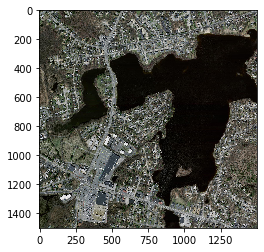

In [88]:
plt.imshow(plt.imread(filename));


In [89]:
with open(filename, 'rb') as f:
    b = bytearray(f.read())

In [90]:
results = deployed_model.predict(b)


In [91]:
import io

mask = np.array(Image.open(io.BytesIO(results)))

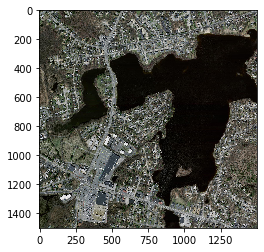

In [92]:
plt.imshow(plt.imread(filename));


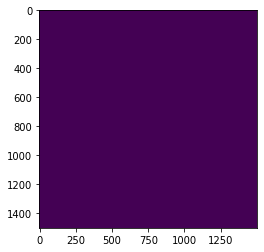

In [93]:
plt.imshow(mask);
